# Setup

In [1]:
packrat::init(project = "/work/postresearch/Shared/Projects/Farbod/CaseMix")

Initializing packrat project in directory:
- "/work/postresearch/Shared/Projects/Farbod/CaseMix"

Initialization complete!



In [2]:
#packrat::snapshot()

In [3]:
packrat::status()

Up to date.



In [4]:
setwd('/work/postresearch/Shared/Projects/Farbod/Integration_Intensity')

In [5]:
options(repr.matrix.max.rows=100, repr.matrix.max.cols=300)
options(repr.plot.width = 20, repr.plot.height = 15)
options(width=300)
    
numcores=128

library(tidyverse)
library(parallel)
library(data.table)
library(fst)
library(comorbidity)
library(zeallot)
library(reshape)
library(dtplyr)
library(haven)
library(vroom)
library(dplyr)
library(icd)
`%!in%` = Negate(`%in%`)

setDTthreads(numcores)

numcores_foreach=128

library(foreach)
library(doMC)
registerDoMC(cores=numcores_foreach)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘reshape’


The following object is masked from ‘package:data.table’:

    melt


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths



Attaching package: ‘icd’


The following object is masked from ‘package:reshape’:

    condense



Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr

In [6]:
#diagnosis codes
#from https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleId=52850&ver=26 and https://www.aapc.com/codes/cpt-codes-range/93451-93533/10
angio_codes=c(93451,93452,93453,93454,93455,93456,93457,93458,93459,93460,93461,93462,93463,93464
              ,93503,93505,93530,93531,93532,93533)
#from https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleid=57326&ver=13&keyword=electrocardiogram&keywordType=starts&areaId=all&docType=NCA,CAL,NCD,MEDCAC,TA,MCD,6,3,5,1,F,P&contractOption=all&sortBy=relevance&bc=1
ecg_codes=c(93000,93005,93010,93040,93041,93042)
#from https://scct.org/page/CardiacCTCodes include CTangio
cardiac_ct_codes=c(75571,75572,75573,75574)
#from https://cardiacmri.com/tech-guide/cpt-codes-relevant-to-cardiac-mri/
cardiac_mri_codes=c(75557,75559,75561,75563,75565)
# from https://medicarepaymentandreimbursement.com/2011/07/cardiovascular-stress-testing-cpt-93015.html and https://www.aapc.com/codes/cpt-codes-range/93000-93050/
stress_test_codes=c(93015,93016,93017,93018)
#from https://www.aapc.com/codes/cpt-codes-range/93303-93356/20     includes stress echo
echocardiography_codes=c(93303,93304,93306,93307,93308,93312,93313,93314,93315,93316,93317,93318
                         ,93320,93321,93325,93350,93351,93356,93352,93355,93356)
#from https://www.aapc.com/codes/cpt-codes-range/92920-92979/ and https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleId=57479#:~:text=CPT%20codes%2092928%2C%2092933%2C%2092929,are%20assigned%20to%20APC%200104.    includes balloon and stent
angioplasty_codes=c(92920,92921,92924,92925,92928,92929,92933,92934,92937,92938,92941,92943,92944
                    ,92973,92974,92975,92978,92979,93571,93572,"C9600","C9601","C9602","C9603"
                    ,"C9604","C9605","C9606","C9607","C9608")
#from https://www.medaxiom.com/clientuploads/webcast_handouts/Coding_for_CABG-Open_Heart_Procedures.pdf and https://www.aapc.com/codes/cpt-codes-range/33016-33999/10    did not include 33517-33530 since these are used in conjunction with 33533-33548 and not alone, did not include 33542,33545,33548 since these are also in conjunction )aneurismectomy and vsd resection
CABG_codes=c(33510,33511,33512,33513,33514,33516,33533,33534,33535,33536)
#from http://www.icd9data.com/2015/Volume1/390-459/430-438/default.htm and https://www.icd10data.com/ICD10CM/Codes/I00-I99/I60-I69/I63-
stroke_icd_9_codes=c(43301,43311,43321,43331,43381,43391,43401,43411,43491)
office_visit_codes=c("99201","99202","99203","99204","99205","99211","99212","99213","99214"
                     ,"99215")
IHD_icd_9_codes=c(410, 411, 412,413,414)
IHD_icd_10_codes=c("I20", "I21", "I22", "I23", "I24", "I25")

non_us_state_codes=c(40,54,56,57,58,59,60,61,62,63,64,65,66,97,98,99)

primary_care_specialty_codes=c("01", "08", "11", "38")
surgery_specialty_codes=c("02","04","14","19","20","24","28","33","34","40","48","77","78","85","91")

#http://www.icd9data.com/2015/Volume1/390-459/401-405/default.htm
#https://www.icd10data.com/ICD10CM/Codes/I00-I99/I10-I16
hypertension_icd_9_codes=c("401","402","403","404","405")
hypertension_icd_10_codes=c("I10","I11","I12","I13","I15","I16")

#http://www.icd9data.com/2014/Volume1/460-519/490-496/default.htm
#https://www.icd10data.com/ICD10CM/Codes/J00-J99/J40-J47
copd_icd_9_codes=c("490","491","492","493","494","495","496")
copd_icd_10_codes=c("J40","J41","J42","J43","J44","J45","J47")

#http://www.icd9data.com/2015/Volume1/240-279/270-279/278/278.htm?__hstc=93424706.cdd51240e438a5219319ce13ccb23860.1648603374124.1648603374124.1648607295327.2&__hssc=93424706.9.1648607295327&__hsfp=908776442
#https://www.icd10data.com/ICD10CM/Codes/E00-E89/E65-E68/E66-
obesity_icd_9_codes=c("2780","V853","V854")
obesity_icd_10_codes=c("E660","E669","Z683","Z684")

#http://www.icd9data.com/2014/Volume1/290-319/295-299/296/default.htm
#https://www.icd10data.com/ICD10CM/Codes/F01-F99/F30-F39
depression_icd_9_codes=c("2962","2963")
depression_icd_10_codes=c("F32","F33")

#http://www.icd9data.com/2015/Volume1/240-279/249-259/default.htm
#https://www.icd10data.com/ICD10CM/Codes/E00-E89/E08-E13
diabetes_icd_9_codes=c("250")
diabetes_icd_10_codes=c("E08","E09","E10","E11","E13")

# adding MDPPAS

In [25]:
yearly_calculations=read.csv("./results_july/stable_data_clean.csv")%>%as.data.table()

In [26]:
yearly_calculations[,most_common_cardiologist_PRF_PHYSN_NPI:=as.character(most_common_cardiologist_PRF_PHYSN_NPI)]

In [27]:
head(yearly_calculations)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,

In [13]:
colnames(yearly_calculations)

[1] "X"                                                                                           "DESY_SORT_KEY"                                                                               "first_diagnosis"                                                                            
  [4] "tot_allowed_carrier"                                                                         "office_visit_count"                                                                          "office_visit_cost_carrier"                                                                  
  [7] "cardiology_visit_count"                                                                      "distinct_clinicians"                                                                         "distinct_cardiologists"                                                                     
 [10] "distinct_primary_care_physicians"                                                            "distinct_surgeons"                                                                           "distinct_other_specialties"                                                                 
 [13] "catheterization_count"                                                                       "catheterization_cost_carrier"                                                                "ecg_count"                                                                                  
 [16] "ecg_cost_carrier"                                                                            "cardiac_ct_count"                                                                            "cardiac_ct_cost_carrier"                                                                    
 [19] "cardiac_mri_count"                                                                           "cardiac_mri_cost_carrier"                                                                    "stress_test_count"                                                                          
 [22] "stress_test_cost_carrier"                                                                    "echocardiography_count"                                                                      "echocardiography_cost_carrier"                                                              
 [25] "angioplasty_count"                                                                           "angioplasty_cost_carrier"                                                                    "CABG_count"                                                                                 
 [28] "CABG_cost_carrier"                                                                           "stable_angina"                                                                               "unstable_angina"                                                                            
 [31] "MI"                                                                                          "MI_date"                                                                                     "cardiac_arrest"                                                                             
 [34] "stroke"                                                                                      "hypertension"                                                                                "copd"                                                                                       
 [37] "obesity"                                                                                     "depression"                                                                                  "diabetes"                                                                                   
 [40] "icd_9_pure"                                                                                  "icd_10_pure"                                                                                 "catheterization_date"                                          

## Read from fst

In [4]:
mdppas_data <- read_fst(path = "/work/postresearch/Shared/Data_raw/Medicare/MDPPAS/mdppas.fst", as.data.table = T)

In [5]:
mdppas_data[,npi:=as.character(npi)]

In [24]:
head(mdppas_data)

npi,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1003000126,2009,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2010,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2011,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2012,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2013,NU00145029,HOSPITALIST MEDICINE PHYSICIANS OF MARYLAND PC,NU00286134,UPMC WESTERN MARYLAND CORPORATION,1
1003000126,2014,NU00145029,HOSPITALIST MEDICINE PHYSICIANS OF MARYLAND PC,,,1


## Add to calculations and integration stats

In [26]:
yearly_calculations <-
  left_join(yearly_calculations, mdppas_data,
    by = c("most_common_cardiologist_PRF_PHYSN_NPI" = "npi", "year_first_diagnosed" = "year")
  ) %>% as.data.table()
head(yearly_calculations)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,

In [28]:
write_fst(x = yearly_calculations, "yearly_calculations_cleaned_with_mdppas.fst", compress = 0)

# Finding integration stats for cardiologists after adding MDPPAS

In [28]:
yearly_calculations = read_fst("yearly_calculations_cleaned_with_mdppas.fst")%>%as.data.table()

In [29]:
yearly_calculations[,
                    most_common_cardiologist_integrated_in_year_of_diagnosis:=(
                      most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >=0.75 |
                      vikeyword == 1
                    )]

In [30]:
head(yearly_calculations[,.(DESY_SORT_KEY,
                            most_common_cardiologist_integrated_in_year_of_diagnosis,
                            most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS,
                            vikeyword
                           )])

DESY_SORT_KEY,most_common_cardiologist_integrated_in_year_of_diagnosis,most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS,vikeyword
<chr>,<lgl>,<dbl>,<dbl>
100004643,FALSE,0.049250535,0
100008543,TRUE,0.860000000,0
100010653,FALSE,0.080310881,0
100010781,TRUE,0.027397260,1
100013703,FALSE,0.006329114,0
100013815,FALSE,0.093220339,0


# Adding MDPPAS to the claim level data to find TINs

## Read data



In [32]:
carrier_data_all_years = read_fst(
    "/work/postresearch/Shared/Projects/Farbod/carrier_data_all_years.fst", as.data.table = T)

### Inpatient files

In [127]:
inpatient_data_2013 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2013.fst",as.data.table = T)
inpatient_data_2014 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2014.fst",as.data.table = T)
inpatient_data_2015 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2015.fst",as.data.table = T)
inpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2016.fst",as.data.table = T)
inpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2017.fst",as.data.table = T)
inpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2018.fst",as.data.table = T)
inpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2019.fst",as.data.table = T)
inpatient_data_2020 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2020.fst",as.data.table = T)

### Outpatient files

In [128]:
outpatient_data_2013 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2013.fst",as.data.table = T)
outpatient_data_2014 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2014.fst",as.data.table = T)
outpatient_data_2015 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2015.fst",as.data.table = T)
outpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2016.fst",as.data.table = T)
outpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2017.fst",as.data.table = T)
outpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2018.fst",as.data.table = T)
outpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2019.fst",as.data.table = T)
outpatient_data_2020 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2020.fst",as.data.table = T)

### Choose columns

In [129]:
choose_columns = function(data_list,
                          columns) {
  require(data.table)
  data_list = lapply(data_list, function (data)
    data [, ..columns])
  result = rbindlist(data_list)
  return(result)
}



outpatient_data_2013_2015 = choose_columns(
  data_list = list(
    outpatient_data_2013,
    outpatient_data_2014,
    outpatient_data_2015
  ),
  columns = c("DESY_SORT_KEY", "CLAIM_NO", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","PRNCPAL_DGNS_VRSN_CD","AT_PHYSN_NPI","PRVDR_NUM")
)
outpatient_data_2013_2015[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

outpatient_data_2016_2020 = choose_columns(
  data_list = list(
    outpatient_data_2016,
    outpatient_data_2017,
    outpatient_data_2018,
    outpatient_data_2019,
    outpatient_data_2020
  ),
  columns = c("DESY_SORT_KEY", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","AT_PHYSN_NPI","PRVDR_NUM")
)
outpatient_data_2016_2020[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

outpatient_data_all_years=rbind(outpatient_data_2013_2015,
                                outpatient_data_2016_2020,fill=T)%>%
                           mutate(PRNCPAL_DGNS_VRSN_CD=replace_na(PRNCPAL_DGNS_VRSN_CD,as.integer(0)))%>%as.data.table
                     
outpatient_data_all_years                     
write_fst(outpatient_data_all_years, "outpatient_data_all_years.fst")

                     
                     
inpatient_data_2013_2015 = choose_columns(
  data_list = list(
    inpatient_data_2013,
    inpatient_data_2014,
    inpatient_data_2015
  ),
  columns = c("DESY_SORT_KEY", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","PRNCPAL_DGNS_VRSN_CD","CLM_DRG_CD","AT_PHYSN_NPI","PRVDR_NUM")
)
inpatient_data_2013_2015[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

inpatient_data_2016_2020 = choose_columns(
  data_list = list(
    inpatient_data_2016,
    inpatient_data_2017,
    inpatient_data_2018,
    inpatient_data_2019,
    inpatient_data_2020
  ),
  columns = c("DESY_SORT_KEY", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","CLM_DRG_CD","AT_PHYSN_NPI","PRVDR_NUM")
)
inpatient_data_2016_2020[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

inpatient_data_all_years=rbind(inpatient_data_2013_2015,
                                inpatient_data_2016_2020,fill=T)%>%
                           mutate(PRNCPAL_DGNS_VRSN_CD=replace_na(PRNCPAL_DGNS_VRSN_CD,as.integer(0)))%>%as.data.table 
                
                     
write_fst(inpatient_data_all_years, "inpatient_data_all_years.fst")
                     

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date
<int>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<date>
100019625,2332,20130101,54.36,V7260,9,1518985670,220105,2013-01-01
100020607,2405,20130101,1108.10,56211,9,1730148677,190040,2013-01-01
100023251,2604,20130101,12042.15,430,9,1043220650,460010,2013-01-01
100023251,2606,20130101,730.01,430,9,1184751547,460021,2013-01-01
100023251,2607,20130101,814.24,78099,9,1184751547,460021,2013-01-01
100042353,5265,20130101,561.00,78652,9,1992750293,310057,2013-01-01
100065729,7971,20130101,2062.00,42731,9,1760435978,070010,2013-01-01
100105419,12494,20130101,2023.60,78900,9,1548467764,150100,2013-01-01
100145101,18268,20130101,152.00,4739,9,1205851078,230004,2013-01-01


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,AT_PHYSN_NPI,PRVDR_NUM,date
<int>,<int>,<dbl>,<chr>,<int>,<chr>,<date>
100032863,20160101,88.90,F329,1780618702,085004,2016-01-01
100037015,20160101,904.70,T18128A,1437103363,100290,2016-01-01
100050593,20160101,3183.00,T85698A,1396856696,310009,2016-01-01
100074175,20160101,1340.60,S0990XA,NA,070034,2016-01-01
100164385,20160101,2414.20,R002,1871522219,150069,2016-01-01
100178855,20160101,1652.00,S52502A,1629172226,150082,2016-01-01
100198717,20160101,260.00,J208,1083843296,111335,2016-01-01
100204021,20160101,471.50,M069,1265670046,330394,2016-01-01
100244315,20160101,4652.00,S2242XA,1396856696,310009,2016-01-01


DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date
<int>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<date>
100000015,2,20130425,3647.00,496,9,1659344091,220071,2013-04-25
100000015,3,20130719,1417.00,496,9,1659344091,220071,2013-07-19
100000015,4,20131014,28.00,V0481,9,1881684439,220071,2013-10-14
100000019,5,20130523,8171.11,53510,9,1790873248,070007,2013-05-23
100000019,6,20130529,3249.00,1541,9,1851359681,070007,2013-05-29
100000019,7,20130603,5759.00,1540,9,1609857119,070007,2013-06-03
100000019,8,20130607,7172.00,1539,9,1942276076,070007,2013-06-07
100000019,9,20130802,8404.30,1539,9,1851359681,070007,2013-08-02
100000019,10,20131026,642.00,7862,9,1609977784,070007,2013-10-26


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date
<int>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<date>
100153533,20130101,19349.20,0389,9,871,1376798108,230156,2013-01-01
100222555,20130101,2766.70,78650,9,313,1811952583,331302,2013-01-01
100335009,20130101,40864.68,51881,9,208,1497732879,100007,2013-01-01
100393077,20130101,15555.00,29421,9,884,1164413159,18S132,2013-01-01
100397165,20130101,20829.20,5990,9,690,1366544405,140114,2013-01-01
100408803,20130101,25413.25,7384,9,552,1205801966,450102,2013-01-01
100425189,20130101,76868.00,57461,9,444,1083707863,100008,2013-01-01
100540009,20130101,9626.43,5849,9,683,1902878739,370037,2013-01-01
100554011,20130101,27640.40,486,9,194,1558373431,450651,2013-01-01


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date
<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<date>
100093217,20160101,107600.00,S72451A,481,1215900659,100157,2016-01-01
100097835,20160101,14677.06,N178,682,1821288960,220031,2016-01-01
100121297,20160101,99816.50,A419,854,1639436066,100017,2016-01-01
100274463,20160101,236784.45,A4151,870,1194873356,390133,2016-01-01
100367273,20160101,111950.25,A021,854,1366471492,010016,2016-01-01
100396827,20160101,8341.74,T8454XA,560,1487722377,360361,2016-01-01
100454975,20160101,14991.15,I214,282,1174522429,230097,2016-01-01
100596793,20160101,75014.41,C186,329,1598717373,040114,2016-01-01
100620981,20160101,8610.72,J209,202,1730142340,440091,2016-01-01


In [56]:
rm("outpatient_data_2013","outpatient_data_2014","outpatient_data_2015","outpatient_data_2016","outpatient_data_2017","outpatient_data_2018","outpatient_data_2019","outpatient_data_2020","inpatient_data_2013","inpatient_data_2014","inpatient_data_2015","inpatient_data_2016","inpatient_data_2017","inpatient_data_2018","inpatient_data_2019","inpatient_data_2020")

In [42]:
outpatient_data_all_years = read_fst(
    "outpatient_data_all_years.fst", as.data.table = T)
inpatient_data_all_years = read_fst(
    "inpatient_data_all_years.fst", as.data.table = T)

In [130]:
outpatient_data_all_years[,year:=as.double(format(date, "%Y"))]
inpatient_data_all_years[,year:=as.double(format(date, "%Y"))]
outpatient_data_all_years[,AT_PHYSN_NPI:=as.character(AT_PHYSN_NPI)]
inpatient_data_all_years[,AT_PHYSN_NPI:=as.character(AT_PHYSN_NPI)]

In [37]:
revenue_center_outpatient_all_years = read_fst(
  "/work/postresearch/Shared/Projects/Data_fst/revenue_center_outpatient_all_years.fst")
outpatient_and_revenue_center_data = read_fst(
  "/work/postresearch/Shared/Projects/Data_fst/outpatient_and_revenue_center_data.fst")

In [131]:
head(carrier_data_all_years)
head(outpatient_data_all_years)
head(inpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",NA,,0,NA,NA,NA,NA,NA,NA
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",NA,,0,NA,NA,NA,NA,NA,NA
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1,NA,NA,NA,NA,NA,NA


DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<date>,<dbl>
100000015,2,20130425,3647.00,496,9,1659344091,220071,2013-04-25,2013
100000015,3,20130719,1417.00,496,9,1659344091,220071,2013-07-19,2013
100000015,4,20131014,28.00,V0481,9,1881684439,220071,2013-10-14,2013
100000019,5,20130523,8171.11,53510,9,1790873248,070007,2013-05-23,2013
100000019,6,20130529,3249.00,1541,9,1851359681,070007,2013-05-29,2013
100000019,7,20130603,5759.00,1540,9,1609857119,070007,2013-06-03,2013


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<date>,<dbl>
100000099,20131027,50625.95,71536,9,470,1639185978,100012,2013-10-27,2013
100000099,20131103,19818.05,99812,9,920,1063619153,100012,2013-11-03,2013
100000315,20130103,53743.47,0090,9,392,1902863236,100239,2013-01-03,2013
100000559,20131224,24659.95,7907,9,871,1578715033,070022,2013-12-24,2013
100000905,20130802,5580.58,5990,9,690,1417187386,220033,2013-08-02,2013
100001177,20130825,9964.00,1889,9,687,1699752303,010169,2013-08-25,2013


## Adding MDPPAS

In [11]:
mdppas_data <- read_fst(path = "/work/postresearch/Shared/Data_raw/Medicare/MDPPAS/mdppas.fst", as.data.table = T)

In [12]:
mdppas_data[,npi:=as.character(npi)]

In [13]:
mdppas_data=mdppas_data[,.(npi,
                           year,
                           tin1_nu,
                           tin1_legal_name,
                           tin2_nu,
                           tin2_legal_name,
                           vikeyword
                          )]

In [33]:
head(mdppas_data)

npi,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1003000126,2009,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2010,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2011,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2012,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,0
1003000126,2013,NU00145029,HOSPITALIST MEDICINE PHYSICIANS OF MARYLAND PC,NU00286134,UPMC WESTERN MARYLAND CORPORATION,1
1003000126,2014,NU00145029,HOSPITALIST MEDICINE PHYSICIANS OF MARYLAND PC,,,1


In [34]:
carrier_data_all_years <-
  left_join(carrier_data_all_years, mdppas_data,
    by = c("PRF_PHYSN_NPI" = "npi", "year" = "year")
  ) %>% as.data.table()
head(carrier_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",,,0
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",,,0
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1


In [132]:
outpatient_data_all_years <-
  left_join(outpatient_data_all_years, mdppas_data,
    by = c("AT_PHYSN_NPI" = "npi", "year" = "year")
  ) %>% as.data.table()
head(outpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000015,2,20130425,3647.00,496,9,1659344091,220071,2013-04-25,2013,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1
100000015,3,20130719,1417.00,496,9,1659344091,220071,2013-07-19,2013,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1
100000015,4,20131014,28.00,V0481,9,1881684439,220071,2013-10-14,2013,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1
100000019,5,20130523,8171.11,53510,9,1790873248,070007,2013-05-23,2013,NU00367159,"SHRI KRIS VERMA, MD",,,0
100000019,6,20130529,3249.00,1541,9,1851359681,070007,2013-05-29,2013,NU00153580,L&M PHYSICIAN ASSOCIATION INC,NU00024609,,0
100000019,7,20130603,5759.00,1540,9,1609857119,070007,2013-06-03,2013,NU00009748,"NEW LONDON CANCER CENTER, P.C",,,0


In [133]:
inpatient_data_all_years <-
  left_join(inpatient_data_all_years, mdppas_data,
    by = c("AT_PHYSN_NPI" = "npi", "year" = "year")
  ) %>% as.data.table()
head(inpatient_data_all_years)

DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000099,20131027,50625.95,71536,9,470,1639185978,100012,2013-10-27,2013,NU00328394,JOINT IMPLANT SURGEONS OF FLORIDA PA,,,0
100000099,20131103,19818.05,99812,9,920,1063619153,100012,2013-11-03,2013,NU00099359,CAPE CORAL HOSPITALISTS INC,,,1
100000315,20130103,53743.47,0090,9,392,1902863236,100239,2013-01-03,2013,NU00332794,GMS FLORIDA WEST COAST INC,NU00330507,BAYFRONT ENTERPRISES INC,0
100000559,20131224,24659.95,7907,9,871,1578715033,070022,2013-12-24,2013,NU00023023,YALE UNIVERSITY,NU00024982,MASONICARE PRIMARY CARE PHYSICIANS,1
100000905,20130802,5580.58,5990,9,690,1417187386,220033,2013-08-02,2013,NU00223515,IPC HOSPITALISTS OF NEW ENGLAND PC,,,1
100001177,20130825,9964.00,1889,9,687,1699752303,010169,2013-08-25,2013,NU00091273,"ATMORE INDUSTRIAL MEDICINE, LLC.",,,0


## Adding most common cardiologist

In [36]:
yearly_calculations_extract=yearly_calculations[,.(DESY_SORT_KEY,
                                                   most_common_cardiologist_PRF_PHYSN_NPI,
                                                   tin1_nu,
                                                   tin1_legal_name,
                                                   tin2_nu,
                                                   tin2_legal_name,
                                                   vikeyword
                                                  )]
yearly_calculations_extract=unique(yearly_calculations_extract)
colnames(yearly_calculations_extract)=c("DESY_SORT_KEY",
                                        "most_common_cardiologist_PRF_PHYSN_NPI",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_vikeyword"
                                       )


In [37]:
yearly_calculations_extract[,DESY_SORT_KEY:=as.integer(DESY_SORT_KEY)]

In [38]:
head(yearly_calculations_extract)

DESY_SORT_KEY,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
100004643,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0
100008543,1700860954,NU00091211,CENTRA MEDICAL GROUP LLC,NU00293513,"CENTRA HEALTH, INC",0
100010653,1801899877,NU00309843,"NUVANCE HEALTH MEDICAL PRACTICE, PC",,,0
100010781,1912991704,NU00286144,JOHNS HOPKINS UNIVERSITY,NU00291537,"GREATER BALTIMORE MEDICAL CENTER, INC.",1
100013703,1982617072,NU00350972,CHARLOTTE HEART AND VASCULAR INSTITUTE PA,NU00333835,SRA VENTURES INC,0
100013815,1619975141,NU00331617,BAY AREA CARDIOLOGY ASSOC. PA,,,0


In [39]:
carrier_data_all_years <-
  left_join(carrier_data_all_years, yearly_calculations_extract,
    by = c("DESY_SORT_KEY" = "DESY_SORT_KEY")
  ) %>% as.data.table()
head(carrier_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",,,0,NA,NA,NA,NA,NA,NA
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",,,0,NA,NA,NA,NA,NA,NA
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1,NA,NA,NA,NA,NA,NA


In [134]:
outpatient_data_all_years <-
  left_join(outpatient_data_all_years, yearly_calculations_extract,
    by = c("DESY_SORT_KEY" = "DESY_SORT_KEY")
  ) %>% as.data.table()
head(outpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000015,2,20130425,3647.00,496,9,1659344091,220071,2013-04-25,2013,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1,NA,NA,NA,NA,NA,NA
100000015,3,20130719,1417.00,496,9,1659344091,220071,2013-07-19,2013,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1,NA,NA,NA,NA,NA,NA
100000015,4,20131014,28.00,V0481,9,1881684439,220071,2013-10-14,2013,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1,NA,NA,NA,NA,NA,NA
100000019,5,20130523,8171.11,53510,9,1790873248,070007,2013-05-23,2013,NU00367159,"SHRI KRIS VERMA, MD",,,0,NA,NA,NA,NA,NA,NA
100000019,6,20130529,3249.00,1541,9,1851359681,070007,2013-05-29,2013,NU00153580,L&M PHYSICIAN ASSOCIATION INC,NU00024609,,0,NA,NA,NA,NA,NA,NA
100000019,7,20130603,5759.00,1540,9,1609857119,070007,2013-06-03,2013,NU00009748,"NEW LONDON CANCER CENTER, P.C",,,0,NA,NA,NA,NA,NA,NA


In [135]:
inpatient_data_all_years <-
  left_join(inpatient_data_all_years, yearly_calculations_extract,
    by = c("DESY_SORT_KEY" = "DESY_SORT_KEY")
  ) %>% as.data.table()
head(inpatient_data_all_years)

DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
100000099,20131027,50625.95,71536,9,470,1639185978,100012,2013-10-27,2013,NU00328394,JOINT IMPLANT SURGEONS OF FLORIDA PA,,,0,NA,NA,NA,NA,NA,NA
100000099,20131103,19818.05,99812,9,920,1063619153,100012,2013-11-03,2013,NU00099359,CAPE CORAL HOSPITALISTS INC,,,1,NA,NA,NA,NA,NA,NA
100000315,20130103,53743.47,0090,9,392,1902863236,100239,2013-01-03,2013,NU00332794,GMS FLORIDA WEST COAST INC,NU00330507,BAYFRONT ENTERPRISES INC,0,NA,NA,NA,NA,NA,NA
100000559,20131224,24659.95,7907,9,871,1578715033,070022,2013-12-24,2013,NU00023023,YALE UNIVERSITY,NU00024982,MASONICARE PRIMARY CARE PHYSICIANS,1,NA,NA,NA,NA,NA,NA
100000905,20130802,5580.58,5990,9,690,1417187386,220033,2013-08-02,2013,NU00223515,IPC HOSPITALISTS OF NEW ENGLAND PC,,,1,NA,NA,NA,NA,NA,NA
100001177,20130825,9964.00,1889,9,687,1699752303,010169,2013-08-25,2013,NU00091273,"ATMORE INDUSTRIAL MEDICINE, LLC.",,,0,NA,NA,NA,NA,NA,NA


In [136]:
head(inpatient_data_all_years[
    !is.na(most_common_cardiologist_PRF_PHYSN_NPI),
    .(DESY_SORT_KEY,
      tin1_legal_name,
      tin2_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name)],10)

DESY_SORT_KEY,tin1_legal_name,tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name
<int>,<chr>,<chr>,<chr>,<chr>
100004643,COASTAL CAROLINA HEALTH CARE PA,CAROLINAEAST MEDICAL CENTER,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",ABBEVILLE GENERAL HOSPITAL
100010653,LLOBET MEDICAL GROUP PLLC,,"NUVANCE HEALTH MEDICAL PRACTICE, PC",
100010653,LLOBET MEDICAL GROUP PLLC,,"NUVANCE HEALTH MEDICAL PRACTICE, PC",
100010653,LLOBET MEDICAL GROUP PLLC,,"NUVANCE HEALTH MEDICAL PRACTICE, PC",
100025251,BERGEN INTERNAL MEDICINE LLC,,"HOLY NAME CARDIOLOGY ASSOCIATES, PC",HMC CARDIAC DIAGNOSTIC SERVICE
100053621,SHEEPSHEAD BAY MEDICAL ASSOCIATES PC,,MAIMONIDES CARDIOLOGY FPP,NEW YORK UNIVERSITY
100080521,SLRHC FACULTY PRACTICE,,ADAM B ROSENBLUTH MD PC,
100116211,WILLIAM W BACKUS HOSPITAL,APOGEE MEDICAL GROUP OF PENNSYLVANIA PC,INTERMOUNTAIN MEDICAL GROUP INC,EKG ASSOCIATES OF WYOMING VALLEY LLP
100168763,SOUND INPATIENT PHYSICIANS MEDICAL GROUP INC,,NORTHBAY HEALTHCARE GROUP,


In [137]:
write_fst(carrier_data_all_years, "carrier_data_all_years_with_tin.fst")
write_fst(outpatient_data_all_years, "outpatient_data_all_years_with_tin.fst")
write_fst(inpatient_data_all_years, "inpatient_data_all_years_with_tin.fst")

## Fixing zero length tins

In [7]:
carrier_data_all_years=read_fst("carrier_data_all_years_with_tin.fst",as.data.table=T)
outpatient_data_all_years=read_fst("outpatient_data_all_years_with_tin.fst",as.data.table=T)
inpatient_data_all_years=read_fst("inpatient_data_all_years_with_tin.fst",as.data.table=T)

In [8]:
carrier_data_all_years[nchar(tin1_nu)==0,tin1_nu:=NA]
carrier_data_all_years[nchar(tin2_nu)==0,tin2_nu:=NA]
carrier_data_all_years[nchar(most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu)==0,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu:=NA]
carrier_data_all_years[nchar(most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu)==0,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu:=NA]

In [9]:
outpatient_data_all_years[nchar(tin1_nu)==0,tin1_nu:=NA]
outpatient_data_all_years[nchar(tin2_nu)==0,tin2_nu:=NA]
outpatient_data_all_years[nchar(most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu)==0,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu:=NA]
outpatient_data_all_years[nchar(most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu)==0,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu:=NA]

In [10]:
inpatient_data_all_years[nchar(tin1_nu)==0,tin1_nu:=NA]
inpatient_data_all_years[nchar(tin2_nu)==0,tin2_nu:=NA]
inpatient_data_all_years[nchar(most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu)==0,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu:=NA]
inpatient_data_all_years[nchar(most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu)==0,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu:=NA]

In [11]:
write_fst(carrier_data_all_years, "carrier_data_all_years_with_tin.fst")
write_fst(outpatient_data_all_years, "outpatient_data_all_years_with_tin.fst")
write_fst(inpatient_data_all_years, "inpatient_data_all_years_with_tin.fst")

# Finding costs

## Finding carrier costs based on TIN

In [36]:
carrier_data_all_years_sample=head(carrier_data_all_years,100000)

In [ ]:
yearly_calculator_patient_conditions = function(data) {
  
  #requirements
  require(data.table)
  require(dtplyr)
  require(tidyverse)
  require(lubridate)
  
  data %>%
    mutate(
      is_cardiology_related = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0, 
        substr(LINE_ICD_DGNS_CD, 0, 1) == "I",
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))>=399 & 
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))<=459 ,NA)),      
      
      is_stable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD %in% c ("I208", "I209"),
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4139", NA)),
      is_unstable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD == "I200",
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4111", NA)),
      
      is_IHD = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0,
        substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_10_codes,
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_9_codes,NA)),
      is_by_cardiologist= PRVDR_SPCLTY %in% c("06","C3"),
        
     same_tin = (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu )
        
    ) %>%
    as.data.table()
}

yearly_patient_conditions_carrier=yearly_calculator_patient_conditions(carrier_data_all_years)
head(yearly_patient_conditions_carrier)


In [ ]:
head(yearly_patient_conditions_carrier[same_tin==T])

In [ ]:
summarise_expenditures_carrier = function(data, time_frame = 365, diagnosis){
  
  data%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis >= 0 &
             date - first_diagnosis < time_frame &
             had_IHD == F,
           .preserve = T) %>%
    summarise(
        
      first_diagnosis = unique(first_diagnosis),
        
      tot_allowed_carrier = sum(na.rm = T, LINE_ALOWD_CHRG_AMT),
      tot_allowed_carrier_same_tin = sum(na.rm = T, LINE_ALOWD_CHRG_AMT * same_tin),
            
      distinct_clinicians = length(unique(PRF_PHYSN_NPI)),
      distinct_cardiologists = length(.[is_by_cardiologist, unique(PRF_PHYSN_NPI)]),
      distinct_clinicians_same_tin = length(.[same_tin==T,unique(PRF_PHYSN_NPI)]),
      distinct_cardiologists_same_tin = length(.[is_by_cardiologist==T&same_tin==T, unique(PRF_PHYSN_NPI)])
    ) %>%
    group_by(DESY_SORT_KEY) %>%
    mutate(
      year_first_diagnosed=year(first_diagnosis),
      tot_allowed_carrier_not_same_tin = tot_allowed_carrier-tot_allowed_carrier_same_tin,
      distinct_clinicians_not_same_tin = distinct_clinicians-distinct_clinicians_same_tin,
      distinct_cardiologists_not_same_tin = distinct_cardiologists-distinct_cardiologists_same_tin
    )%>%
    as.data.table()
}


summary = summarise_expenditures_carrier(yearly_patient_conditions_carrier , diagnosis = "stable_angina")
head(summary)


In [38]:
write_fst(summary,"summarise_expenditures_carrier.fst")

### Summarizing cardiology related patient data 

In [ ]:
add_cardiology_related_expenditures_carrier = function(data, summary_data, time_frame = 365, diagnosis){
  
  data%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis >= 0 &
             date - first_diagnosis < time_frame &
             had_IHD == F &
             is_cardiology_related,
           .preserve = T) %>%
    summarise(        
      tot_allowed_carrier_cardiology_related = sum(na.rm = T, LINE_ALOWD_CHRG_AMT),
      tot_allowed_carrier_same_tin_cardiology_related = sum(na.rm = T, LINE_ALOWD_CHRG_AMT * same_tin)
    ) %>%
    group_by(DESY_SORT_KEY) %>%
    mutate(
      tot_allowed_carrier_not_same_tin_cardiology_related = tot_allowed_carrier_cardiology_related-tot_allowed_carrier_same_tin_cardiology_related,
    )%>%
    left_join(summary_data, . , by = "DESY_SORT_KEY")%>%
    as.data.table()
}

summary_with_cardiology_related = add_cardiology_related_expenditures_carrier(yearly_patient_conditions_carrier, summary , diagnosis = "stable_angina")
head(summary_with_cardiology_related)

In [37]:
write_fst(summary_with_cardiology_related,"summary_with_cardiology_related.fst")

## Adding inpatient and outpatient expenditure data

Adding the data to the yearly calculations with an inner join so I will only have data for stable/unstable angina patients. I will also filter based on date in this part.


In [ ]:
outpatient_data_all_years_stable_angina=inner_join(outpatient_data_all_years, summary_with_cardiology_related,by="DESY_SORT_KEY")%>%as.data.table()
inpatient_data_all_years_stable_angina=inner_join(inpatient_data_all_years, summary_with_cardiology_related,by="DESY_SORT_KEY")%>%as.data.table()

In [ ]:
outpatient_data_all_years_stable_angina[,
    same_tin := (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu ) & vikeyword==T]

inpatient_data_all_years_stable_angina[,
    same_tin := (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu ) & vikeyword==T]

In [ ]:
outpatient_data_all_years_stable_angina[,
    same_tin := (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu ) ]

inpatient_data_all_years_stable_angina[,
    same_tin := (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu ) ]

In [15]:
head(outpatient_data_all_years_stable_angina)
head(inpatient_data_all_years_stable_angina)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword,first_diagnosis,tot_allowed_carrier_last_year,year_first_diagnosed,tot_allowed_carrier_last__cardiology_related
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
100005675,581,20130403,316.34,2859,9,1558377663,220046,2013-04-03,2013,NU00048557,,NA,,0,NA,NA,NA,NA,NA,NA,2020-07-06,8681.37,2020,4923.70
100005675,582,20130514,221.22,7862,9,1558377663,220046,2013-05-14,2013,NU00048557,,NA,,0,NA,NA,NA,NA,NA,NA,2020-07-06,8681.37,2020,4923.70
100005675,583,20130807,316.34,2859,9,1558377663,220046,2013-08-07,2013,NU00048557,,NA,,0,NA,NA,NA,NA,NA,NA,2020-07-06,8681.37,2020,4923.70
100005675,584,20131003,256.91,V7612,9,1558377663,220046,2013-10-03,2013,NU00048557,,NA,,0,NA,NA,NA,NA,NA,NA,2020-07-06,8681.37,2020,4923.70
100005675,585,20131030,328.99,2869,9,1558377663,220046,2013-10-30,2013,NU00048557,,NA,,0,NA,NA,NA,NA,NA,NA,2020-07-06,8681.37,2020,4923.70
100007109,731,20130801,943.00,25070,9,1518997352,070031,2013-08-01,2013,NU00128055,"PULMONARY SPECIALTIES, P.C.",NA,,0,NA,NA,NA,NA,NA,NA,2013-12-26,5715.94,2013,1951.53


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword,first_diagnosis,tot_allowed_carrier_last_year,year_first_diagnosed,tot_allowed_carrier_last__cardiology_related
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
100004643,20130308,8189.33,43491,9,65,1639140775,340131,2013-03-08,2013,NU00307185,COASTAL CAROLINA HEALTH CARE PA,NU00304387,CAROLINAEAST MEDICAL CENTER,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,1846.32,2018,664.53
100008015,20130221,18795.06,92400,9,605,1205873254,220100,2013-02-21,2013,NU00014619,COASTAL MEDICAL ASSOCIATES,NA,,0,NA,NA,NA,NA,NA,NA,2013-02-18,684.51,2013,NA
100010653,20130419,29569.65,51881,9,208,1518020502,330004,2013-04-19,2013,NU00132556,LLOBET MEDICAL GROUP PLLC,NA,,0,1801899877,NU00309843,"NUVANCE HEALTH MEDICAL PRACTICE, PC",NA,,0,2014-02-14,10405.41,2014,72.68
100010653,20131108,30880.60,51881,9,208,1518020502,330004,2013-11-08,2013,NU00132556,LLOBET MEDICAL GROUP PLLC,NA,,0,1801899877,NU00309843,"NUVANCE HEALTH MEDICAL PRACTICE, PC",NA,,0,2014-02-14,10405.41,2014,72.68
100010653,20131230,40478.25,51881,9,208,1518020502,330004,2013-12-30,2013,NU00132556,LLOBET MEDICAL GROUP PLLC,NA,,0,1801899877,NU00309843,"NUVANCE HEALTH MEDICAL PRACTICE, PC",NA,,0,2014-02-14,10405.41,2014,72.68
100025229,20130727,46464.95,72402,9,0,1689675274,030085,2013-07-27,2013,NU00415083,TUCSON ORTHOPAEDIC INSTITUTE PROFESSIONAL CORPORATION,NA,,0,NA,NA,NA,NA,NA,NA,2020-09-03,3934.44,2020,302.34


In [36]:
write_fst(outpatient_data_all_years_stable_angina,"outpatient_data_all_years_stable_angina.fst")
write_fst(inpatient_data_all_years_stable_angina,"inpatient_data_all_years_stable_angina.fst")

### Adding AHA data for diagnosis

In [220]:
aha_data=readxl::read_xlsx("/work/postresearch/Shared/Projects/Farbod/AHA_data/financial_profile.xlsx")%>% as.data.table()
colnames(aha_data)=as.character(aha_data[4,])
aha_data=aha_data[-(1:4),c("Medicare Provider ID","Hospital Name")]
colnames(aha_data)=c("PRVDR_NUM","hospital_name")
head(aha_data)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
• `` -> `...20`
• `` -> `...21`
• `` -> `...22`
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`
• `` -> `...26`
• `` -> `...27`
• `` -> `...28`
• `` -> `...29`
• `` -> `...30`
• `` -> `...31`
• `` -> `...32`
• `` -> `...33`
• `` -> `...34`
• `` -> `...35`
• `` -> `...36`
• `` -> `...37`
• `` -> `...38`
• `` -> `...39`
• `` -> `...40`
• `` -> `...41`
• `` -> `...42`


PRVDR_NUM,hospital_name
<chr>,<chr>
010001,Southeast Alabama Medical Center
010005,Marshall Medical Center South
010006,Eliza Coffee Memorial Hospital
010007,Mizell Memorial Hospital
010008,Crenshaw Community Hospital
010011,St. Vincent's East


In [221]:
inpatient_data_all_years_stable_angina=left_join(inpatient_data_all_years_stable_angina,aha_data,by="PRVDR_NUM")%>%as.data.table()
outpatient_data_all_years_stable_angina=left_join(outpatient_data_all_years_stable_angina,aha_data,by="PRVDR_NUM")%>%as.data.table()

In [14]:
head(inpatient_data_all_years_stable_angina[
    !is.na(most_common_cardiologist_PRF_PHYSN_NPI)&
    date>=first_diagnosis & date-first_diagnosis<365,
    .(DESY_SORT_KEY,
      AT_PHYSN_NPI,
      most_common_cardiologist_PRF_PHYSN_NPI,
      
      tin1_nu,
      tin2_nu,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,
      
      tin1_legal_name,
      tin2_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,
      hospital_name,
      vikeyword,
      
      same_tin
     )],10)

head(outpatient_data_all_years_stable_angina[
    !is.na(most_common_cardiologist_PRF_PHYSN_NPI)&
    date>=first_diagnosis & date-first_diagnosis<365,
    .(DESY_SORT_KEY,
      AT_PHYSN_NPI,
      most_common_cardiologist_PRF_PHYSN_NPI,
      
      tin1_nu,
      tin2_nu,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,
      
      tin1_legal_name,
      tin2_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,
      hospital_name,
      vikeyword,
      
      same_tin
     )],10)

ERROR: Error: Internal error: storage mode of IDate is somehow no longer integer


In [228]:
to_review_inpatient_data=
outpatient_data_all_years_stable_angina[
    !is.na(most_common_cardiologist_PRF_PHYSN_NPI)&
    date>=first_diagnosis & date-first_diagnosis<365&
    same_tin==T,
    .(DESY_SORT_KEY,
      AT_PHYSN_NPI,
      most_common_cardiologist_PRF_PHYSN_NPI,
      
      tin1_nu,
      tin2_nu,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,
      
      tin1_legal_name,
      tin2_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,
      most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,
      hospital_name,
      vikeyword,
      same_tin
     )]

In [229]:
head(to_review_inpatient_data)

DESY_SORT_KEY,AT_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI,tin1_nu,tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,tin1_legal_name,tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,hospital_name,vikeyword,same_tin
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>
100008543,1710936182,1700860954,NU00091211,NA,NU00091211,NU00293513,CENTRA MEDICAL GROUP LLC,,CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",Centra Lynchburg General Hospital,0,TRUE
100008543,1386628774,1700860954,NU00091211,NU00293513,NU00091211,NU00293513,CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",Centra Lynchburg General Hospital,0,TRUE
100008543,1700860954,1700860954,NU00091211,NU00293513,NU00091211,NU00293513,CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",Centra Lynchburg General Hospital,0,TRUE
100008543,1861590929,1700860954,NU00091211,NU00305505,NU00091211,NU00293513,CENTRA MEDICAL GROUP LLC,PIEDMONT STONE CENTER PLLC,CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",Centra Lynchburg General Hospital,0,TRUE
100008543,1215906128,1700860954,NU00091211,NA,NU00091211,NU00293513,CENTRA MEDICAL GROUP LLC,,CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",Centra Lynchburg General Hospital,0,TRUE
100008543,1740231638,1700860954,NU00091211,NA,NU00091211,NU00293513,CENTRA MEDICAL GROUP LLC,,CENTRA MEDICAL GROUP LLC,"CENTRA HEALTH, INC",Centra Lynchburg General Hospital,0,TRUE


In [230]:
write.csv(to_review_inpatient_data,"to_review_inpatient_data_no_vikey.csv")

### Calculate total costs
This will take the outpatient and inpatient data and retun the total outpatient and inpatient expenditure. It also asks for the time frame which will be compared to the date first diagnosed. I will keep using yearly here.

In [203]:
#outpatient
yearly_tot_outpatient=function(data,time_frame=365){
  data%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_outpatient=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_outpatient_same_tin = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_outpatient_not_same_tin = tot_allowed_outpatient-tot_allowed_outpatient_same_tin)%>%
    as.data.table()
}

yearly_tot_outpatient_cardiology_related=function(data,time_frame=365){
  data%>%
  mutate(is_cardiology_related = if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
      PRNCPAL_DGNS_VRSN_CD == 9,
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA)))%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame & is_cardiology_related)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_outpatient_cardiology_related=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_outpatient_same_tin_cardiology_related = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_outpatient_not_same_tin_cardiology_related = tot_allowed_outpatient_cardiology_related-tot_allowed_outpatient_same_tin_cardiology_related)%>%
    as.data.table()
}

#inpatient
yearly_tot_inpatient=function(data,time_frame=365){
  data%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_inpatient=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_inpatient_same_tin = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_inpatient_not_same_tin = tot_allowed_inpatient-tot_allowed_inpatient_same_tin)%>%
    as.data.table()
}

yearly_tot_inpatient_cardiology_related=function(data,time_frame=365){
  data%>%
  mutate(is_cardiology_related = if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
      PRNCPAL_DGNS_VRSN_CD == 9,
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA)))%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame & is_cardiology_related)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_inpatient_cardiology_related=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_inpatient_same_tin_cardiology_related = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_inpatient_not_same_tin_cardiology_related = tot_allowed_inpatient_cardiology_related-tot_allowed_inpatient_same_tin_cardiology_related)%>%
    as.data.table()
}



outpatient_tot_yearly_stable_angina=yearly_tot_outpatient(outpatient_data_all_years_stable_angina)
inpatient_tot_yearly_stable_angina=yearly_tot_inpatient(inpatient_data_all_years_stable_angina)

outpatient_tot_yearly_stable_angina_cardiology_related=
yearly_tot_outpatient_cardiology_related(outpatient_data_all_years_stable_angina)
inpatient_tot_yearly_stable_angina_cardiology_related=
yearly_tot_inpatient_cardiology_related(inpatient_data_all_years_stable_angina)


Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”


In [204]:
head(outpatient_tot_yearly_stable_angina)
head(inpatient_tot_yearly_stable_angina)
head(outpatient_tot_yearly_stable_angina_cardiology_related)
head(inpatient_tot_yearly_stable_angina_cardiology_related)

DESY_SORT_KEY,tot_allowed_outpatient,tot_allowed_outpatient_same_tin,tot_allowed_outpatient_not_same_tin
<int>,<dbl>,<dbl>,<dbl>
100007109,1078.50,0.00,1078.50
100008015,7092.44,0.00,7092.44
100008543,6337.03,6337.03,0.00
100010653,176109.78,304.00,175805.78
100010781,17704.68,0.00,17704.68
100013703,1037.85,0.00,1037.85


DESY_SORT_KEY,tot_allowed_inpatient,tot_allowed_inpatient_same_tin,tot_allowed_inpatient_not_same_tin
<int>,<dbl>,<dbl>,<dbl>
100005675,250422.85,0.0,250422.85
100008015,18795.06,0.0,18795.06
100010653,311264.38,261333.9,49930.50
100010781,13915.48,0.0,13915.48
100011457,75944.80,0.0,75944.80
100013393,167851.00,0.0,167851.00


DESY_SORT_KEY,tot_allowed_outpatient_cardiology_related,tot_allowed_outpatient_same_tin_cardiology_related,tot_allowed_outpatient_not_same_tin_cardiology_related
<int>,<dbl>,<dbl>,<dbl>
100008543,372.60,372.6,0.00
100010781,12305.11,0.0,12305.11
100014335,825.00,0.0,825.00
100015949,248.44,0.0,248.44
100023001,12830.08,0.0,12830.08
100025251,2750.00,2750.0,0.00


DESY_SORT_KEY,tot_allowed_inpatient_cardiology_related,tot_allowed_inpatient_same_tin_cardiology_related,tot_allowed_inpatient_not_same_tin_cardiology_related
<int>,<dbl>,<dbl>,<dbl>
100005675,250422.85,0,250422.85
100010781,13915.48,0,13915.48
100014335,52263.44,0,52263.44
100025251,18549.43,0,18549.43
100046919,529428.34,0,529428.34
100050761,113407.00,0,113407.00


### Adding the outpatient and inpatient results to the carrier results
I will also find the total expenditure in one year

In [205]:
#stable angina
yearly_calculations_stable_angina=summary_with_cardiology_related

yearly_calculations_stable_angina=left_join(yearly_calculations_stable_angina, outpatient_tot_yearly_stable_angina, by="DESY_SORT_KEY")%>%as.data.table()
yearly_calculations_stable_angina=left_join(yearly_calculations_stable_angina, inpatient_tot_yearly_stable_angina, by="DESY_SORT_KEY")%>%as.data.table()

yearly_calculations_stable_angina=
left_join(yearly_calculations_stable_angina, outpatient_tot_yearly_stable_angina_cardiology_related, by="DESY_SORT_KEY")%>%as.data.table()
yearly_calculations_stable_angina=
left_join(yearly_calculations_stable_angina, inpatient_tot_yearly_stable_angina_cardiology_related, by="DESY_SORT_KEY")%>%as.data.table()

#finding the total expenditure in one year
yearly_calculations_stable_angina[,`:=`(total_exp=sum(tot_allowed_carrier,tot_allowed_outpatient,tot_allowed_inpatient,na.rm = T),
                                        total_exp_cardiology_related=sum(tot_allowed_carrier_cardiology_related,tot_allowed_outpatient_cardiology_related,tot_allowed_inpatient_cardiology_related,na.rm = T),
                                        
                                        total_exp_same_tin=sum(tot_allowed_carrier_same_tin,tot_allowed_outpatient_same_tin,tot_allowed_inpatient_same_tin,na.rm = T),
                                        total_exp_same_tin_cardiology_related=sum(tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_outpatient_same_tin_cardiology_related,tot_allowed_inpatient_same_tin_cardiology_related,na.rm = T),
                                        
                                        total_exp_not_same_tin=sum(tot_allowed_carrier_not_same_tin,tot_allowed_outpatient_not_same_tin,tot_allowed_inpatient_not_same_tin,na.rm = T),
                                        total_exp_not_same_tin_cardiology_related=sum(tot_allowed_carrier_not_same_tin_cardiology_related,tot_allowed_outpatient_not_same_tin_cardiology_related,tot_allowed_inpatient_not_same_tin_cardiology_related,na.rm = T)
                                        ),
                                        by=DESY_SORT_KEY]


In [206]:
head(yearly_calculations_stable_angina)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin,tot_allowed_carrier_cardiology_related,tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_carrier_not_same_tin_cardiology_related,tot_allowed_outpatient,tot_allowed_outpatient_same_tin,tot_allowed_outpatient_not_same_tin,tot_allowed_inpatient,tot_allowed_inpatient_same_tin,tot_allowed_inpatient_not_same_tin,tot_allowed_outpatient_cardiology_related,tot_allowed_outpatient_same_tin_cardiology_related,tot_allowed_outpatient_not_same_tin_cardiology_related,tot_allowed_inpatient_cardiology_related,tot_allowed_inpatient_same_tin_cardiology_related,tot_allowed_inpatient_not_same_tin_cardiology_related,total_exp,total_exp_cardiology_related,total_exp_same_tin,total_exp_same_tin_cardiology_related,total_exp_not_same_tin,total_exp_not_same_tin_cardiology_related
<int>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100004643,2018-07-24,2164.96,1345.60,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.20,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2164.96,1098.55,1345.60,310.35,819.36,788.20
100005675,2020-07-06,4598.06,0.00,20,5,0,0,2020,4598.06,20,5,2699.46,0.00,2699.46,NA,NA,NA,250422.85,0.0,250422.85,NA,NA,NA,250422.9,0,250422.9,255020.91,253122.31,0.00,0.00,255020.91,253122.31
100007109,2013-12-26,2257.14,0.00,10,1,0,0,2013,2257.14,10,1,871.19,0.00,871.19,1078.50,0.00,1078.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,3335.64,871.19,0.00,0.00,3335.64,871.19
100008015,2013-02-18,13622.46,0.00,26,3,0,0,2013,13622.46,26,3,2126.04,0.00,2126.04,7092.44,0.00,7092.44,18795.06,0.0,18795.06,NA,NA,NA,NA,NA,NA,39509.96,2126.04,0.00,0.00,39509.96,2126.04
100008543,2014-04-16,2149.56,899.06,22,4,13,4,2014,1250.50,9,0,178.71,106.90,71.81,6337.03,6337.03,0.00,NA,NA,NA,372.6,372.6,0,NA,NA,NA,8486.59,551.31,7236.09,479.50,1250.50,71.81
100010653,2014-02-14,16861.51,2848.26,49,9,12,3,2014,14013.25,37,6,3309.14,1035.17,2273.97,176109.78,304.00,175805.78,311264.38,261333.9,49930.50,NA,NA,NA,NA,NA,NA,504235.67,3309.14,264486.14,1035.17,239749.53,2273.97


In [207]:
nrow(yearly_calculations_stable_angina)

[1] 38419

In [208]:
colnames(yearly_calculations_stable_angina)

[1] "DESY_SORT_KEY"                                          "first_diagnosis"                                        "tot_allowed_carrier"                                    "tot_allowed_carrier_same_tin"                           "distinct_clinicians"                                   
 [6] "distinct_cardiologists"                                 "distinct_clinicians_same_tin"                           "distinct_cardiologists_same_tin"                        "year_first_diagnosed"                                   "tot_allowed_carrier_not_same_tin"                      
[11] "distinct_clinicians_not_same_tin"                       "distinct_cardiologists_not_same_tin"                    "tot_allowed_carrier_cardiology_related"                 "tot_allowed_carrier_same_tin_cardiology_related"        "tot_allowed_carrier_not_same_tin_cardiology_related"   
[16] "tot_allowed_outpatient"                                 "tot_allowed_outpatient_same_tin"                        "tot_allowed_outpatient_not_same_tin"                    "tot_allowed_inpatient"                                  "tot_allowed_inpatient_same_tin"                        
[21] "tot_allowed_inpatient_not_same_tin"                     "tot_allowed_outpatient_cardiology_related"              "tot_allowed_outpatient_same_tin_cardiology_related"     "tot_allowed_outpatient_not_same_tin_cardiology_related" "tot_allowed_inpatient_cardiology_related"              
[26] "tot_allowed_inpatient_same_tin_cardiology_related"      "tot_allowed_inpatient_not_same_tin_cardiology_related"  "total_exp"                                              "total_exp_cardiology_related"                           "total_exp_same_tin"                                    
[31] "total_exp_same_tin_cardiology_related"                  "total_exp_not_same_tin"                                 "total_exp_not_same_tin_cardiology_related"

In [209]:
yearly_calculations_stable_angina[,DESY_SORT_KEY:=as.character(DESY_SORT_KEY)]

# Finding last year's costs

In [7]:
carrier_data_all_years=read_fst( "carrier_data_all_years_with_tin.fst")
outpatient_data_all_years=read_fst( "outpatient_data_all_years_with_tin.fst")
inpatient_data_all_years=read_fst( "inpatient_data_all_years_with_tin.fst")

## Finding carrier costs

In [8]:
yearly_calculator_patient_conditions = function(data) {
  
  #requirements
  require(data.table)
  require(dtplyr)
  require(tidyverse)
  require(lubridate)
  
  data %>%
    mutate(
      is_cardiology_related = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0, 
        substr(LINE_ICD_DGNS_CD, 0, 1) == "I",
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))>=399 & 
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))<=459 ,NA)),      
      
      is_stable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD %in% c ("I208", "I209"),
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4139", NA)),
      is_unstable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD == "I200",
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4111", NA)),
      
      is_IHD = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0,
        substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_10_codes,
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_9_codes,NA)),
      is_by_cardiologist= PRVDR_SPCLTY %in% c("06","C3")
    ) %>%
    as.data.table()
}

yearly_patient_conditions_carrier=yearly_calculator_patient_conditions(carrier_data_all_years)
head(yearly_patient_conditions_carrier)


Loading required package: lubridate


Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week, yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Warning message in if_else(LINE_ICD_DGNS_VRSN_CD == 9, as.numeric(substr(LINE_ICD_DGNS_CD, :
“NAs introduced by coercion”
Warning message in if_else(LINE_ICD_DGNS_VRSN_CD == 9, as.numeric(substr(LINE_ICD_DGNS_CD, :
“NAs introduced by coercion”


DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword,is_cardiology_related,is_stable_angina,is_unstable_angina,is_IHD,is_by_cardiologist
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,NU00013485,THE GENERAL HOSPITAL CORPORATION,0,NA,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",NA,,0,NA,NA,NA,NA,NA,NA,TRUE,FALSE,FALSE,TRUE,FALSE
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,"SALIL K MIDHA, MD, PC",NA,,0,NA,NA,NA,NA,NA,NA,TRUE,FALSE,FALSE,TRUE,FALSE
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,THE GENERAL HOSPITAL CORPORATION,NU00013835,MASSACHUSETTS GENERAL PHYSICIANS ORGANIZATION INC,1,NA,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE


In [9]:
summarise_expenditures_carrier = function(data, time_frame = 365, diagnosis){
  
  data%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis < 0 &
             first_diagnosis - date  <= time_frame &
             had_IHD == F,
           .preserve = T) %>%
    summarise(
        
      first_diagnosis = unique(first_diagnosis),
        
      tot_allowed_carrier_last_year = sum(na.rm = T, LINE_ALOWD_CHRG_AMT)
      
    ) %>%
    group_by(DESY_SORT_KEY) %>%
    mutate(
      year_first_diagnosed=year(first_diagnosis)
    )%>%
    as.data.table()
}


summary = summarise_expenditures_carrier(yearly_patient_conditions_carrier , diagnosis = "stable_angina")
head(summary)


DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier_last_year,year_first_diagnosed
<int>,<date>,<dbl>,<dbl>
100004643,2018-07-24,1846.32,2018
100005675,2020-07-06,8681.37,2020
100007109,2013-12-26,5715.94,2013
100008015,2013-02-18,684.51,2013
100008543,2014-04-16,6542.70,2014
100010653,2014-02-14,10405.41,2014


### Summarizing cardiology related patient data 

In [11]:
add_cardiology_related_expenditures_carrier = function(data, summary_data, time_frame = 365, diagnosis){
  
  data%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis < 0 &
             first_diagnosis - date  <= time_frame &
             had_IHD == F &
             is_cardiology_related,
           .preserve = T) %>%
    summarise(        
      tot_allowed_carrier_last_year_cardiology_related = sum(na.rm = T, LINE_ALOWD_CHRG_AMT),
    ) %>%
    left_join(summary_data, . , by = "DESY_SORT_KEY")%>%
    as.data.table()
}

summary_with_cardiology_related = add_cardiology_related_expenditures_carrier(yearly_patient_conditions_carrier, summary , diagnosis = "stable_angina")
head(summary_with_cardiology_related)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier_last_year,year_first_diagnosed,tot_allowed_carrier_last__cardiology_related
<int>,<date>,<dbl>,<dbl>,<dbl>
100004643,2018-07-24,1846.32,2018,664.53
100005675,2020-07-06,8681.37,2020,4923.70
100007109,2013-12-26,5715.94,2013,1951.53
100008015,2013-02-18,684.51,2013,NA
100008543,2014-04-16,6542.70,2014,418.53
100010653,2014-02-14,10405.41,2014,72.68


### Calculate total costs
This will take the outpatient and inpatient data and retun the total outpatient and inpatient expenditure. It also asks for the time frame which will be compared to the date first diagnosed. I will keep using yearly here.

In [16]:
outpatient_data_all_years_stable_angina=read_fst("outpatient_data_all_years_stable_angina.fst",as.data.table=T)
inpatient_data_all_years_stable_angina=read_fst("inpatient_data_all_years_stable_angina.fst",as.data.table=T)

In [17]:
#outpatient
yearly_tot_outpatient=function(data,time_frame=365){
  data%>%
    filter(date - first_diagnosis < 0 &
             first_diagnosis - date  <= time_frame)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_outpatient_last_year=sum(CLM_TOT_CHRG_AMT,na.rm=T)
             )%>%
    as.data.table()
}

yearly_tot_outpatient_cardiology_related=function(data,time_frame=365){
  data%>%
  mutate(is_cardiology_related = if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
      PRNCPAL_DGNS_VRSN_CD == 9,
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA)))%>%
    filter(date - first_diagnosis < 0 &
             first_diagnosis - date  <= time_frame & is_cardiology_related)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_outpatient_last_year_cardiology_related=sum(CLM_TOT_CHRG_AMT,na.rm=T))%>%
    as.data.table()
}

#inpatient
yearly_tot_inpatient=function(data,time_frame=365){
  data%>%
    filter(date - first_diagnosis < 0 &
             first_diagnosis - date  <= time_frame)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_inpatient_last_year=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              )%>%
    as.data.table()
}

yearly_tot_inpatient_cardiology_related=function(data,time_frame=365){
  data%>%
  mutate(is_cardiology_related = if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
      PRNCPAL_DGNS_VRSN_CD == 9,
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA)))%>%
    filter(date - first_diagnosis < 0 &
             first_diagnosis - date  <= time_frame & is_cardiology_related)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_inpatient_last_year_cardiology_related=sum(CLM_TOT_CHRG_AMT,na.rm=T))%>%
    as.data.table()
}



outpatient_tot_yearly_stable_angina=yearly_tot_outpatient(outpatient_data_all_years_stable_angina)
inpatient_tot_yearly_stable_angina=yearly_tot_inpatient(inpatient_data_all_years_stable_angina)

outpatient_tot_yearly_stable_angina_cardiology_related=
yearly_tot_outpatient_cardiology_related(outpatient_data_all_years_stable_angina)
inpatient_tot_yearly_stable_angina_cardiology_related=
yearly_tot_inpatient_cardiology_related(inpatient_data_all_years_stable_angina)


Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”


In [18]:
head(outpatient_tot_yearly_stable_angina)
head(inpatient_tot_yearly_stable_angina)
head(outpatient_tot_yearly_stable_angina_cardiology_related)
head(inpatient_tot_yearly_stable_angina_cardiology_related)

DESY_SORT_KEY,tot_allowed_outpatient_last_year
<int>,<dbl>
100005675,5211.36
100007109,64727.60
100008543,10892.84
100010653,126403.91
100010781,15921.19
100013393,2521.00


DESY_SORT_KEY,tot_allowed_inpatient_last_year
<int>,<dbl>
100004643,15092.00
100005675,76501.83
100010653,100928.50
100010781,4330.01
100013393,124251.00
100013815,47741.72


DESY_SORT_KEY,tot_allowed_outpatient_last_year_cardiology_related
<int>,<dbl>
100005675,275.95
100007109,25506.60
100008543,292.25
100010781,11938.47
100013703,3039.92
100013815,29915.92


DESY_SORT_KEY,tot_allowed_inpatient_last_year_cardiology_related
<int>,<dbl>
100004643,15092.00
100005675,54329.42
100010781,4330.01
100013815,47741.72
100031159,732312.52
100045883,15918.19


### Adding the outpatient and inpatient results to the carrier results
I will also find the total expenditure in one year

In [25]:
#stable angina
yearly_calculations_stable_angina=summary_with_cardiology_related

yearly_calculations_stable_angina=left_join(yearly_calculations_stable_angina, outpatient_tot_yearly_stable_angina, by="DESY_SORT_KEY")%>%as.data.table()
yearly_calculations_stable_angina=left_join(yearly_calculations_stable_angina, inpatient_tot_yearly_stable_angina, by="DESY_SORT_KEY")%>%as.data.table()

yearly_calculations_stable_angina=
left_join(yearly_calculations_stable_angina, outpatient_tot_yearly_stable_angina_cardiology_related, by="DESY_SORT_KEY")%>%as.data.table()
yearly_calculations_stable_angina=
left_join(yearly_calculations_stable_angina, inpatient_tot_yearly_stable_angina_cardiology_related, by="DESY_SORT_KEY")%>%as.data.table()

#finding the total expenditure in one year
yearly_calculations_stable_angina[,`:=`(total_exp_last_year=sum(tot_allowed_carrier_last_year,tot_allowed_outpatient_last_year,tot_allowed_inpatient_last_year,na.rm = T),
                                        total_exp_last_year_cardiology_related=sum(tot_allowed_carrier_last_year_cardiology_related,tot_allowed_outpatient_last_year_cardiology_related,tot_allowed_inpatient_last_year_cardiology_related,na.rm = T)
                                       ),
                                        by=DESY_SORT_KEY]


In [26]:
head(yearly_calculations_stable_angina)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier_last_year,year_first_diagnosed,tot_allowed_carrier_last_year_cardiology_related,tot_allowed_outpatient_last_year,tot_allowed_inpatient_last_year,tot_allowed_outpatient_last_year_cardiology_related,tot_allowed_inpatient_last_year_cardiology_related,total_exp_last_year,total_exp_last_year_cardiology_related
<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100004643,2018-07-24,1846.32,2018,664.53,NA,15092.00,NA,15092.00,16938.32,15756.53
100005675,2020-07-06,8681.37,2020,4923.70,5211.36,76501.83,275.95,54329.42,90394.56,59529.07
100007109,2013-12-26,5715.94,2013,1951.53,64727.60,NA,25506.60,NA,70443.54,27458.13
100008015,2013-02-18,684.51,2013,NA,NA,NA,NA,NA,684.51,0.00
100008543,2014-04-16,6542.70,2014,418.53,10892.84,NA,292.25,NA,17435.54,710.78
100010653,2014-02-14,10405.41,2014,72.68,126403.91,100928.50,NA,NA,237737.82,72.68


In [27]:
nrow(yearly_calculations_stable_angina)

[1] 37394

In [28]:
colnames(yearly_calculations_stable_angina)

[1] "DESY_SORT_KEY"                                       "first_diagnosis"                                     "tot_allowed_carrier_last_year"                       "year_first_diagnosed"                                "tot_allowed_carrier_last_year_cardiology_related"   
 [6] "tot_allowed_outpatient_last_year"                    "tot_allowed_inpatient_last_year"                     "tot_allowed_outpatient_last_year_cardiology_related" "tot_allowed_inpatient_last_year_cardiology_related"  "total_exp_last_year"                                
[11] "total_exp_last_year_cardiology_related"

In [29]:
yearly_calculations_stable_angina[,DESY_SORT_KEY:=as.character(DESY_SORT_KEY)]

In [34]:
yearly_calculations_stable_angina=yearly_calculations_stable_angina[,-c(2,4)]

## Adding last year costs to the calcualtions

In [39]:
yearly_calculations=read.csv("./yearly_calculations_with_part_a_b.csv")%>%as.data.table()

In [40]:
yearly_calculations[,DESY_SORT_KEY:=as.character(DESY_SORT_KEY)]

In [41]:
head(yearly_calculations)

X,...1,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_

In [42]:
yearly_calculations=left_join(yearly_calculations,yearly_calculations_stable_angina,
                             by=c("DESY_SORT_KEY"))%>%as.data.table

In [43]:
head(yearly_calculations)

X,...1,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_

In [44]:
yearly_calculations[1:10,.(DESY_SORT_KEY,total_exp,total_exp_last_year)]

DESY_SORT_KEY,total_exp,total_exp_last_year
<chr>,<dbl>,<dbl>
100004643,2164.96,16938.32
100008543,8486.59,17435.54
100010653,504235.67,237737.82
100010781,44798.59,28847.55
100013703,7446.81,5669.95
100013815,1615.67,94244.44
100015949,34796.74,17401.37
100016989,7160.71,3707.12
100023001,32223.07,NA


In [45]:
yearly_calculations=yearly_calculations[,-c(1,2)]

In [46]:
head(yearly_calculations)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,HM

In [48]:
nrow(yearly_calculations)

[1] 14554

In [47]:
write.csv(yearly_calculations,"./yearly_calculations_with_part_a_b_last_year_costs.csv")

# Adding MDPPAS with TIN costs to the original calculations

In [210]:
yearly_calculations_with_tin=left_join(yearly_calculations,
                                       yearly_calculations_stable_angina[,.(DESY_SORT_KEY,
                                                                            tot_allowed_carrier_same_tin,
                                                                            tot_allowed_carrier_not_same_tin,
                                                                            distinct_clinicians_same_tin,
                                                                            distinct_cardiologists_same_tin,
                                                                            distinct_clinicians_not_same_tin,
                                                                            distinct_cardiologists_not_same_tin,
                                                                            tot_allowed_carrier_same_tin_cardiology_related,
                                                                            tot_allowed_carrier_not_same_tin_cardiology_related,
                                                                            tot_allowed_outpatient_same_tin,
                                                                            tot_allowed_outpatient_not_same_tin,
                                                                            tot_allowed_inpatient_same_tin,
                                                                            tot_allowed_inpatient_not_same_tin,
                                                                            tot_allowed_outpatient_same_tin_cardiology_related,
                                                                            tot_allowed_outpatient_not_same_tin_cardiology_related,
                                                                            tot_allowed_inpatient_same_tin_cardiology_related,
                                                                            tot_allowed_inpatient_not_same_tin_cardiology_related,
                                                                            total_exp_same_tin,
                                                                            total_exp_same_tin_cardiology_related,
                                                                            total_exp_not_same_tin,
                                                                            total_exp_not_same_tin_cardiology_related
                                                                           )],
                                       by="DESY_SORT_KEY"
                                      )%>%as.data.table()

In [211]:
head(yearly_calculations_with_tin)
nrow(yearly_calculations_with_tin)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,

[1] 14554

In [195]:
write_fst(yearly_calculations_with_tin,"yearly_calculations_with_tin.fst")

# Finding cost differences

In [52]:
yearly_calculations_with_tin=read_fst("yearly_calculations_with_tin.fst", as.data.table=T)

In [56]:
nrow(yearly_calculations_with_tin)

[1] 14554

In [196]:
write.csv(yearly_calculations_with_tin,"yearly_calculations_with_tin.csv")

In [116]:
colnames(yearly_calculations_with_tin)

[1] "X"                                                                                           "DESY_SORT_KEY"                                                                               "first_diagnosis"                                                                            
  [4] "tot_allowed_carrier"                                                                         "office_visit_count"                                                                          "office_visit_cost_carrier"                                                                  
  [7] "cardiology_visit_count"                                                                      "distinct_clinicians"                                                                         "distinct_cardiologists"                                                                     
 [10] "distinct_primary_care_physicians"                                                            "distinct_surgeons"                                                                           "distinct_other_specialties"                                                                 
 [13] "catheterization_count"                                                                       "catheterization_cost_carrier"                                                                "ecg_count"                                                                                  
 [16] "ecg_cost_carrier"                                                                            "cardiac_ct_count"                                                                            "cardiac_ct_cost_carrier"                                                                    
 [19] "cardiac_mri_count"                                                                           "cardiac_mri_cost_carrier"                                                                    "stress_test_count"                                                                          
 [22] "stress_test_cost_carrier"                                                                    "echocardiography_count"                                                                      "echocardiography_cost_carrier"                                                              
 [25] "angioplasty_count"                                                                           "angioplasty_cost_carrier"                                                                    "CABG_count"                                                                                 
 [28] "CABG_cost_carrier"                                                                           "stable_angina"                                                                               "unstable_angina"                                                                            
 [31] "MI"                                                                                          "MI_date"                                                                                     "cardiac_arrest"                                                                             
 [34] "stroke"                                                                                      "hypertension"                                                                                "copd"                                                                                       
 [37] "obesity"                                                                                     "depression"                                                                                  "diabetes"                                                                                   
 [40] "icd_9_pure"                                                                                  "icd_10_pure"                                                                                 "catheterization_date"                                          

In [8]:
intensity_comparator_averages=function(data){
  
  require(tidyverse)
  require(dtplyr)
  
  
      
  result=data%>%
    group_by(most_common_cardiologist_integrated_in_year_of_diagnosis)%>%
    summarise(
        
      n=n(),
        
      N_distinct_patients=length(unique(DESY_SORT_KEY)),
        
      Male=mean(sex=="Male",na.rm=T),
      Female=mean(sex=="Female",na.rm=T),
      Asian=mean(race=="Asian",na.rm=T),
      Black=mean(race=="Black",na.rm=T),
      Hispanic=mean(race=="Hispanic",na.rm=T),
      North_American_Native=mean(race=="North American Native",na.rm=T),
      White=mean(race=="White",na.rm=T),
      Other=mean(race=="Other",na.rm=T),
      avg_age=mean(age_at_diagnosis,na.rm=T),
      age_65_74=mean(na.rm=T,age_group=="65-74"),
      age_75_84=mean(na.rm=T,age_group=="75-84"),
      age_85_plus=mean(na.rm=T,age_group=="85+"),
        
      West=mean(na.rm=T,census_region=="West"),
      South=mean(na.rm=T,census_region=="South"),
      Northeast=mean(na.rm=T,census_region=="Northeast"),
      Midwest=mean(na.rm=T,census_region=="Midwest"),
      
      rural_prp=mean(RUCC_2013>3,na.rm = T),
      urban_prp=mean(RUCC_2013<=3,na.rm = T),
      
      year_of_diagnsosis_2014=mean(na.rm=T,year_first_diagnosed=="2014"),
      year_of_diagnsosis_2015=mean(na.rm=T,year_first_diagnosed=="2015"),
      year_of_diagnsosis_2016=mean(na.rm=T,year_first_diagnosed=="2016"),
      year_of_diagnsosis_2017=mean(na.rm=T,year_first_diagnosed=="2017"),
      year_of_diagnsosis_2018=mean(na.rm=T,year_first_diagnosed=="2018"),
      year_of_diagnsosis_2019=mean(na.rm=T,year_first_diagnosed=="2019"),
    
      mean_weighted_charlson=mean(wscore,na.rm=T),
      
      distinct_clinicians=sum(na.rm=T,distinct_clinicians)/n(),
      distinct_cardiologists=sum(na.rm=T,distinct_cardiologists)/n(),
      distinct_primary_care_physicians=sum(na.rm=T,distinct_primary_care_physicians)/n(),
      distinct_surgeons=sum(na.rm=T,distinct_surgeons)/n(),
      distinct_other_specialties=sum(na.rm=T,distinct_other_specialties)/n(),
        
      distinct_clinicians_same_tin=sum(na.rm=T,distinct_clinicians_same_tin)/n(),
      distinct_cardiologists_same_tin=sum(na.rm=T,distinct_cardiologists_same_tin)/n(),
    
      
      total_exp_cardiology_related=sum(na.rm=T,total_exp_cardiology_related)/n(),
      tot_allowed_inpatient_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_cardiology_related)/n(),
      tot_allowed_outpatient_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_cardiology_related)/n(),
      tot_allowed_carrier_cardiology_related=sum(na.rm=T,tot_allowed_carrier_cardiology_related)/n(),
      
      total_exp=sum(na.rm=T,total_exp)/n(),
      tot_allowed_inpatient=sum(na.rm=T,tot_allowed_inpatient)/n(),
      tot_allowed_outpatient=sum(na.rm=T,tot_allowed_outpatient)/n(),
      tot_allowed_carrier=sum(na.rm=T,tot_allowed_carrier)/n(),

        
        
      total_exp_same_tin=sum(na.rm=T,total_exp_same_tin)/n(),
      tot_allowed_inpatient_same_tin=sum(na.rm=T,tot_allowed_inpatient_same_tin)/n(),
      tot_allowed_outpatient_same_tin=sum(na.rm=T,tot_allowed_outpatient_same_tin)/n(),
      tot_allowed_carrier_same_tin=sum(na.rm=T,tot_allowed_carrier_same_tin)/n(),
        
      total_exp_same_tin_cardiology_related=sum(na.rm=T,total_exp_same_tin_cardiology_related)/n(),
      tot_allowed_inpatient_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_same_tin_cardiology_related)/n(),
      tot_allowed_outpatient_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_same_tin_cardiology_related)/n(),
      tot_allowed_carrier_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_carrier_same_tin_cardiology_related)/n(),
        
        
        
      total_exp_not_same_tin=sum(na.rm=T,total_exp_not_same_tin)/n(),
      tot_allowed_inpatient_not_same_tin=sum(na.rm=T,tot_allowed_inpatient_not_same_tin)/n(),
      tot_allowed_outpatient_not_same_tin=sum(na.rm=T,tot_allowed_outpatient_not_same_tin)/n(),
      tot_allowed_carrier_not_same_tin=sum(na.rm=T,tot_allowed_carrier_not_same_tin)/n(),
        
      total_exp_not_same_tin_cardiology_related=sum(na.rm=T,total_exp_not_same_tin_cardiology_related)/n(),
      tot_allowed_inpatient_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_not_same_tin_cardiology_related)/n(),
      tot_allowed_outpatient_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_not_same_tin_cardiology_related)/n(),
      tot_allowed_carrier_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_carrier_not_same_tin_cardiology_related)/n(),
        
      
     
        
      
      cheap_prcdr_cost=sum(na.rm=T,tot_cheap_prcdr_cost)/n(),
      expensive_prcdr_cost=sum(na.rm=T,tot_expensive_prcdr_cost)/n(),  
      
      unstable_angina=sum(na.rm=T,unstable_angina)/n(),
      MI_prp=sum(na.rm=T,MI)/n(),
      cardiac_arrest=sum(na.rm=T,cardiac_arrest)/n(),
      stroke=sum(na.rm=T,stroke)/n(),
      
      died_in_one_year_after_diagnosis=sum(na.rm=T,died_in_one_year_after_diagnosis)/n(),
      died_in_two_years_after_diagnosis=sum(na.rm=T,died_in_two_years_after_diagnosis)/n(),
      
      number_of_hospitalizations=sum(na.rm=T,number_of_hospitalizations)/n(),
      hospitalized_patients=sum(na.rm=T,was_hospitalized)/n(),
    )%>%
    as.data.table()
  
  return(result)
}



In [9]:
intensity_comparisons_averages=intensity_comparator_averages(yearly_calculations_with_tin)
t(intensity_comparisons_averages)

most_common_cardiologist_integrated_in_year_of_diagnosis,NA,0.000000e+00,1.000000e+00
n,1.000000e+01,1.146300e+04,3.081000e+03
N_distinct_patients,1.000000e+01,1.146300e+04,3.081000e+03
Male,4.000000e-01,5.016139e-01,5.287244e-01
Female,6.000000e-01,4.983861e-01,4.712756e-01
Asian,1.000000e-01,2.241996e-02,1.493022e-02
Black,1.000000e-01,6.586408e-02,7.140539e-02
Hispanic,0.000000e+00,1.744744e-02,8.438819e-03
North_American_Native,0.000000e+00,3.227776e-03,8.438819e-03
White,7.000000e-01,8.628631e-01,8.682246e-01
Other,1.000000e-01,1.683678e-02,1.493022e-02


## Just costs

In [12]:
intensity_comparator_averages=function(data){
  
  require(tidyverse)
  require(dtplyr)
  
  
      
  result=data%>%
    group_by(most_common_cardiologist_integrated_in_year_of_diagnosis)%>%
    summarise(
      
    n=n(),
      
    N_distinct_patients=length(unique(DESY_SORT_KEY)),
    
    
    
    
    mean_total_exp=sum(na.rm=T,total_exp)/n(),
    mean_tot_allowed_inpatient=sum(na.rm=T,tot_allowed_inpatient)/n(),
    mean_tot_allowed_outpatient=sum(na.rm=T,tot_allowed_outpatient)/n(),
    mean_tot_allowed_carrier=sum(na.rm=T,tot_allowed_carrier)/n(),
    mean_total_exp_cardiology_related=sum(na.rm=T,total_exp_cardiology_related)/n(),
    mean_tot_allowed_inpatient_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_cardiology_related)/n(),
    mean_tot_allowed_outpatient_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_cardiology_related)/n(),
    mean_tot_allowed_carrier_cardiology_related=sum(na.rm=T,tot_allowed_carrier_cardiology_related)/n(), 
    mean_total_exp_same_tin=sum(na.rm=T,total_exp_same_tin)/n(),
    mean_tot_allowed_inpatient_same_tin=sum(na.rm=T,tot_allowed_inpatient_same_tin)/n(),
    mean_tot_allowed_outpatient_same_tin=sum(na.rm=T,tot_allowed_outpatient_same_tin)/n(),
    mean_tot_allowed_carrier_same_tin=sum(na.rm=T,tot_allowed_carrier_same_tin)/n(),
    mean_total_exp_same_tin_cardiology_related=sum(na.rm=T,total_exp_same_tin_cardiology_related)/n(),
    mean_tot_allowed_inpatient_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_same_tin_cardiology_related)/n(),
    mean_tot_allowed_outpatient_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_same_tin_cardiology_related)/n(),
    mean_tot_allowed_carrier_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_carrier_same_tin_cardiology_related)/n(),
    mean_total_exp_not_same_tin=sum(na.rm=T,total_exp_not_same_tin)/n(),
    mean_tot_allowed_inpatient_not_same_tin=sum(na.rm=T,tot_allowed_inpatient_not_same_tin)/n(),
    mean_tot_allowed_outpatient_not_same_tin=sum(na.rm=T,tot_allowed_outpatient_not_same_tin)/n(),
    mean_tot_allowed_carrier_not_same_tin=sum(na.rm=T,tot_allowed_carrier_not_same_tin)/n(),
    mean_total_exp_not_same_tin_cardiology_related=sum(na.rm=T,total_exp_not_same_tin_cardiology_related)/n(),
    mean_tot_allowed_inpatient_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_not_same_tin_cardiology_related)/n(),
    mean_tot_allowed_outpatient_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_not_same_tin_cardiology_related)/n(),
    mean_tot_allowed_carrier_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_carrier_not_same_tin_cardiology_related)/n(),
        
      

    sd_total_exp=sd(na.rm=T,total_exp),
    sd_tot_allowed_inpatient=sd(na.rm=T,tot_allowed_inpatient),
    sd_tot_allowed_outpatient=sd(na.rm=T,tot_allowed_outpatient),
    sd_tot_allowed_carrier=sd(na.rm=T,tot_allowed_carrier),
    sd_total_exp_cardiology_related=sd(na.rm=T,total_exp_cardiology_related),
    sd_tot_allowed_inpatient_cardiology_related=sd(na.rm=T,tot_allowed_inpatient_cardiology_related),
    sd_tot_allowed_outpatient_cardiology_related=sd(na.rm=T,tot_allowed_outpatient_cardiology_related),
    sd_tot_allowed_carrier_cardiology_related=sd(na.rm=T,tot_allowed_carrier_cardiology_related),
    sd_total_exp_same_tin=sd(na.rm=T,total_exp_same_tin),
    sd_tot_allowed_inpatient_same_tin=sd(na.rm=T,tot_allowed_inpatient_same_tin),
    sd_tot_allowed_outpatient_same_tin=sd(na.rm=T,tot_allowed_outpatient_same_tin),
    sd_tot_allowed_carrier_same_tin=sd(na.rm=T,tot_allowed_carrier_same_tin),
    sd_total_exp_same_tin_cardiology_related=sd(na.rm=T,total_exp_same_tin_cardiology_related),
    sd_tot_allowed_inpatient_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_inpatient_same_tin_cardiology_related),
    sd_tot_allowed_outpatient_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_outpatient_same_tin_cardiology_related),
    sd_tot_allowed_carrier_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_carrier_same_tin_cardiology_related),
    sd_total_exp_not_same_tin=sd(na.rm=T,total_exp_not_same_tin),
    sd_tot_allowed_inpatient_not_same_tin=sd(na.rm=T,tot_allowed_inpatient_not_same_tin),
    sd_tot_allowed_outpatient_not_same_tin=sd(na.rm=T,tot_allowed_outpatient_not_same_tin),
    sd_tot_allowed_carrier_not_same_tin=sd(na.rm=T,tot_allowed_carrier_not_same_tin), 
    sd_total_exp_not_same_tin_cardiology_related=sd(na.rm=T,total_exp_not_same_tin_cardiology_related),
    sd_tot_allowed_inpatient_not_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_inpatient_not_same_tin_cardiology_related),
    sd_tot_allowed_outpatient_not_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_outpatient_not_same_tin_cardiology_related),
    sd_tot_allowed_carrier_not_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_carrier_not_same_tin_cardiology_related),
    )%>%
    
    
    as.data.table()
  
  return(result)
}



In [13]:
intensity_comparisons_averages=intensity_comparator_averages(yearly_calculations_with_tin)
t(intensity_comparisons_averages)

most_common_cardiologist_integrated_in_year_of_diagnosis,NA,0.0000,1.0000
n,10.0000,11463.0000,3081.0000
N_distinct_patients,10.0000,11463.0000,3081.0000
mean_total_exp,47444.1730,109939.8165,103775.2091
mean_tot_allowed_inpatient,28584.7330,56108.3368,52256.2205
mean_tot_allowed_outpatient,14433.1690,46336.9362,44961.7526
mean_tot_allowed_carrier,4426.2710,7494.5434,6557.2360
mean_total_exp_cardiology_related,11917.3430,43997.4870,44994.4675
mean_tot_allowed_inpatient_cardiology_related,10053.4290,27571.3089,27797.5202
mean_tot_allowed_outpatient_cardiology_related,1001.7800,14546.2988,15567.2017
mean_tot_allowed_carrier_cardiology_related,862.1340,1879.8792,1629.7456


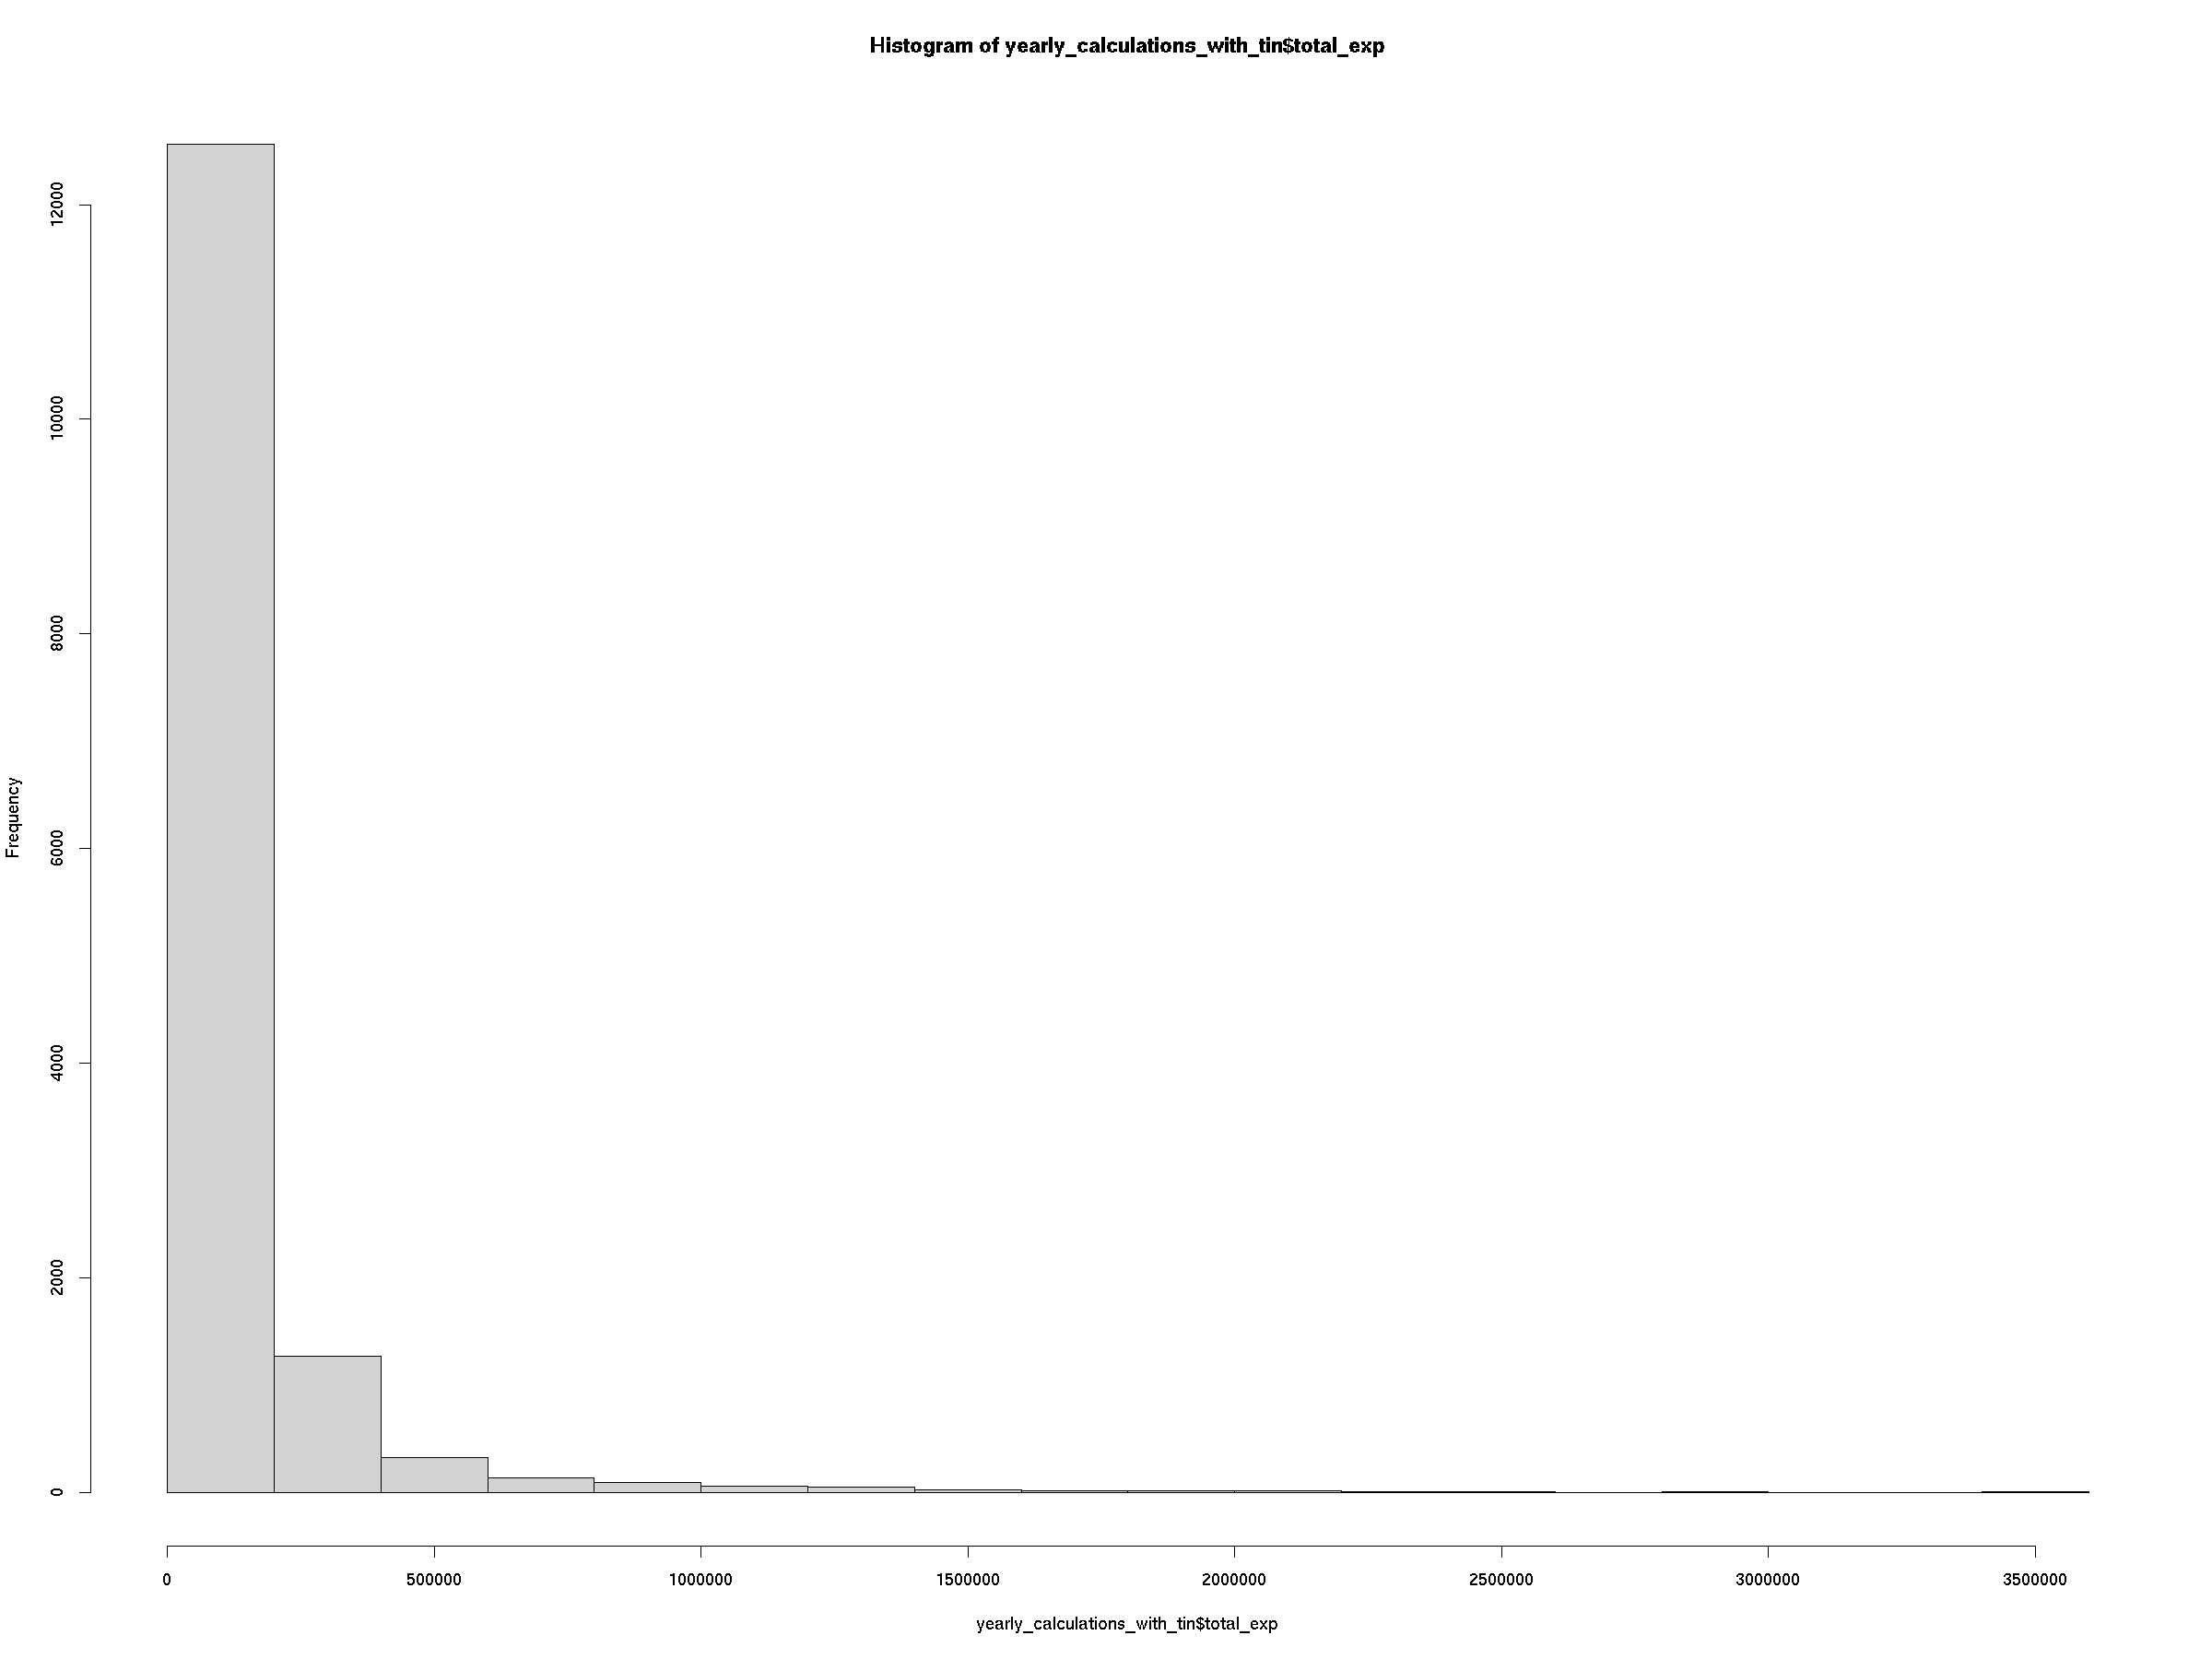

In [121]:
hist(yearly_calculations_with_tin$total_exp)

## Tests

In [122]:
intensity_comparator_t_test_averages=function(data){
  
  require(tidyverse)
  require(dtplyr)
  
  
      
  result=data%>%
    summarise(      
        t_test_total_exp=t.test(data=.,total_exp~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient=t.test(data=.,tot_allowed_inpatient~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient=t.test(data=.,tot_allowed_outpatient~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier=t.test(data=.,tot_allowed_carrier~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value, 
        t_test_total_exp_cardiology_related=t.test(data=.,total_exp_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_cardiology_related=t.test(data=.,tot_allowed_inpatient_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_cardiology_related=t.test(data=.,tot_allowed_outpatient_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_cardiology_related=t.test(data=.,tot_allowed_carrier_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value, 
        t_test_total_exp_same_tin=t.test(data=.,total_exp_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_same_tin=t.test(data=.,tot_allowed_inpatient_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_same_tin=t.test(data=.,tot_allowed_outpatient_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_same_tin=t.test(data=.,tot_allowed_carrier_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_total_exp_same_tin_cardiology_related=t.test(data=.,total_exp_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_same_tin_cardiology_related=t.test(data=.,tot_allowed_inpatient_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_same_tin_cardiology_related=t.test(data=.,tot_allowed_outpatient_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_same_tin_cardiology_related=t.test(data=.,tot_allowed_carrier_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_total_exp_not_same_tin=t.test(data=.,total_exp_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_not_same_tin=t.test(data=.,tot_allowed_inpatient_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_not_same_tin=t.test(data=.,tot_allowed_outpatient_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_not_same_tin=t.test(data=.,tot_allowed_carrier_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_total_exp_not_same_tin_cardiology_related=t.test(data=.,total_exp_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_not_same_tin_cardiology_related=t.test(data=.,tot_allowed_inpatient_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_not_same_tin_cardiology_related=t.test(data=.,tot_allowed_outpatient_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_not_same_tin_cardiology_related=t.test(data=.,tot_allowed_carrier_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value
    )%>%
    as.data.table()
    
  return(result)
}

In [123]:
intensity_comparisons_t_test=intensity_comparator_t_test_averages(yearly_calculations_with_tin)
t(intensity_comparisons_t_test)

t_test_total_exp,9.400884e-02
t_test_tot_allowed_inpatient,1.210316e-01
t_test_tot_allowed_outpatient,5.447125e-01
t_test_tot_allowed_carrier,3.938575e-06
t_test_total_exp_cardiology_related,5.579329e-01
t_test_tot_allowed_inpatient_cardiology_related,8.801796e-01
t_test_tot_allowed_outpatient_cardiology_related,1.130218e-01
t_test_tot_allowed_carrier_cardiology_related,4.885447e-07
t_test_total_exp_same_tin,1.888159e-23
t_test_tot_allowed_inpatient_same_tin,7.030098e-16
t_test_tot_allowed_outpatient_same_tin,1.048794e-07


# HHI calculations

In [11]:
carrier_data_all_years = read_fst(
    "carrier_data_all_years_with_tin.fst", as.data.table = T)


In [6]:
outpatient_data_all_years_stable_angina=read_fst("outpatient_data_all_years_stable_angina.fst", as.data.table = T)
inpatient_data_all_years_stable_angina=read_fst("inpatient_data_all_years_stable_angina.fst", as.data.table = T)

## Carrier

In [12]:
carrier_patient_conditions_finder_for_hhi = function(data,time_frame=365,diagnosis = "stable_angina") {
  
  #requirements
  require(data.table)
  require(dtplyr)
  require(tidyverse)
  require(lubridate)
  
  data %>%
    mutate(
      is_cardiology_related = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0, 
        substr(LINE_ICD_DGNS_CD, 0, 1) == "I",
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))>=399 & 
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))<=459 ,NA)),      
      
      is_stable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD %in% c ("I208", "I209"),
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4139", NA)),
      is_unstable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD == "I200",
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4111", NA)),
      
      is_IHD = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0,
        substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_10_codes,
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_9_codes,NA)),
      is_by_cardiologist= PRVDR_SPCLTY %in% c("06","C3"),
        
     same_tin = (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu )
        
    )%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis >= 0 &
             date - first_diagnosis < time_frame &
             had_IHD == F,
           .preserve = T) %>%
    as.data.table()
}

carrier_patient_conditions_for_hhi=carrier_patient_conditions_finder_for_hhi(carrier_data_all_years)
head(carrier_patient_conditions_for_hhi)


Loading required package: lubridate


Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week, yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Warning message in fifelse(LINE_ICD_DGNS_VRSN_CD == 9, as.numeric(substr(LINE_ICD_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(LINE_ICD_DGNS_VRSN_CD == 9, as.numeric(substr(LINE_ICD_DGNS_CD, :
“NAs introduced by coercion”


DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword,is_cardiology_related,is_stable_angina,is_unstable_angina,is_IHD,is_by_cardiologist,same_tin,first_diagnosis,na.rm,had_IHD
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<date>,<lgl>,<lgl>
100004643,1609,1,20180724,11,99214,0,I209,104.30,1922000801,06,19,2018-07-24,2018,2018-07,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,2018-07-24,TRUE,FALSE
100004643,1610,1,20180725,11,93280,0,R001,38.27,1922000801,06,19,2018-07-25,2018,2018-07,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,2018-07-24,TRUE,FALSE
100004643,1611,1,20180730,12,99490,0,I10,34.79,1144223207,89,19,2018-07-30,2018,2018-07,NU00252377,"HOMEDICA OF LOUISIANA, LLC",NU00251838,MED HOUSE CALLS LLC,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2018-07-24,TRUE,FALSE
100004643,1612,1,20180814,12,99349,0,I10,108.38,1144223207,89,19,2018-08-14,2018,2018-08,NU00252377,"HOMEDICA OF LOUISIANA, LLC",NU00251838,MED HOUSE CALLS LLC,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2018-07-24,TRUE,FALSE
100004643,1613,1,20180829,11,93880,0,I6523,189.79,1922000801,06,19,2018-08-29,2018,2018-08,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,2018-07-24,TRUE,FALSE
100004643,1614,1,20181113,12,99349,0,I10,108.38,1144223207,89,19,2018-11-13,2018,2018-11,NU00252377,"HOMEDICA OF LOUISIANA, LLC",NU00251838,MED HOUSE CALLS LLC,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2018-07-24,TRUE,FALSE


In [13]:
carrier_hhi=carrier_patient_conditions_for_hhi[!is.na(most_common_cardiologist_PRF_PHYSN_NPI),
                                                        .(tot_allowed_carrier = sum(na.rm = T, LINE_ALOWD_CHRG_AMT))
                                                        ,keyby=.(most_common_cardiologist_PRF_PHYSN_NPI,tin1_nu)]


carrier_hhi[,sum_cardiologist:=sum(tot_allowed_carrier),keyby=.(most_common_cardiologist_PRF_PHYSN_NPI)]
carrier_hhi[,share:=tot_allowed_carrier*100/sum_cardiologist]




carrier_hhi_cardiology_related=carrier_patient_conditions_for_hhi[!is.na(most_common_cardiologist_PRF_PHYSN_NPI)&
                                                                           is_cardiology_related==T,
                                                                           .(tot_allowed_carrier = sum(na.rm = T, LINE_ALOWD_CHRG_AMT))
                                                                           ,keyby=.(most_common_cardiologist_PRF_PHYSN_NPI,tin1_nu)]

carrier_hhi_cardiology_related[,sum_cardiologist:=sum(tot_allowed_carrier),keyby=.(most_common_cardiologist_PRF_PHYSN_NPI)]
carrier_hhi_cardiology_related[,share:=tot_allowed_carrier*100/sum_cardiologist]

In [15]:
tail(carrier_hhi)
tail(carrier_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,tin1_nu,tot_allowed_carrier,sum_cardiologist,share
<chr>,<chr>,<dbl>,<dbl>,<dbl>
9999999992,NU00340262,372.42,19784.26,1.88240551
9999999992,NU00348506,11.48,19784.26,0.05802593
9999999992,NU00351737,65.24,19784.26,0.32975709
9999999992,NU00359038,68.02,19784.26,0.34380866
9999999992,NU00359232,299.10,19784.26,1.51180787
9999999992,NU00360214,101.92,19784.26,0.51515700


most_common_cardiologist_PRF_PHYSN_NPI,tin1_nu,tot_allowed_carrier,sum_cardiologist,share
<chr>,<chr>,<dbl>,<dbl>,<dbl>
9999999992,NU00090479,9.16,1101.1,0.8318954
9999999992,NU00100623,281.74,1101.1,25.5871401
9999999992,NU00114334,154.00,1101.1,13.9860140
9999999992,NU00134539,196.56,1101.1,17.8512397
9999999992,NU00234047,289.52,1101.1,26.2937063
9999999992,NU00327591,84.37,1101.1,7.6623377


### Check missingness of tin

In [16]:
integration_data=read.csv("stable_vilist.csv")%>%as.data.table()

In [19]:
integration_data=unique(integration_data[,.(npicommoncardiodx,newcardiodxstatus)])
integration_data[,npicommoncardiodx:=as.character(npicommoncardiodx)]
head(integration_data)

npicommoncardiodx,newcardiodxstatus
<chr>,<int>
1003000936,0
1003007170,1
1003009861,0
1003019563,1
1003022708,0
1003029869,0


In [20]:
carrier_hhi=left_join(carrier_hhi,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()
carrier_hhi_cardiology_related=left_join(carrier_hhi_cardiology_related,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()

In [32]:
mssingness_comparator=function(data){
    missing_prp=data[!is.na(newcardiodxstatus),.(missing_prp=mean(is.na(tin1_nu))),keyby=newcardiodxstatus]
    t_test=data[!is.na(newcardiodxstatus),.(p_value=t.test(is.na(tin1_nu)~newcardiodxstatus)$p.value)]
    cbind(missing_prp,t_test)
}

In [33]:
mssingness_comparator(carrier_hhi)

newcardiodxstatus,missing_prp,p_value
<int>,<dbl>,<dbl>
0,0.06132091,7.957573e-08
1,0.06915396,7.957573e-08


In [34]:
mssingness_comparator(carrier_hhi_cardiology_related)

newcardiodxstatus,missing_prp,p_value
<int>,<dbl>,<dbl>
0,0.1046608,0.4650631
1,0.1024799,0.4650631


In [35]:
write.csv(carrier_hhi,"carrier_hhi_before_hhi.csv")
write.csv(carrier_hhi_cardiology_related,"carrier_hhi_cardiology_related_before_hhi.csv")

### calculate HHI

In [50]:
carrier_hhi=read.csv("carrier_hhi_before_hhi.csv")%>%as.data.table()
carrier_hhi_cardiology_related=read.csv("carrier_hhi_cardiology_related_before_hhi.csv")%>%as.data.table()

In [51]:
head(carrier_hhi)

X,most_common_cardiologist_PRF_PHYSN_NPI,tin1_nu,tot_allowed_carrier,sum_cardiologist,share,newcardiodxstatus
<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,1003000936,NA,1760.33,12966.16,13.5763403,0
2,1003000936,NU00100276,896.71,12966.16,6.9157715,0
3,1003000936,NU00133445,306.23,12966.16,2.3617632,0
4,1003000936,NU00149570,5444.65,12966.16,41.9912295,0
5,1003000936,NU00166296,112.12,12966.16,0.8647125,0
6,1003000936,NU00244107,170.89,12966.16,1.3179692,0


In [52]:
carrier_hhi=carrier_hhi[!is.na(tin1_nu),]
carrier_hhi=carrier_hhi[,.(hhi=sum(share^2)),keyby=most_common_cardiologist_PRF_PHYSN_NPI]
carrier_hhi_cardiology_related=carrier_hhi_cardiology_related[,.(hhi=sum(share^2)),keyby=most_common_cardiologist_PRF_PHYSN_NPI]

In [55]:
carrier_hhi[,most_common_cardiologist_PRF_PHYSN_NPI:=as.character(most_common_cardiologist_PRF_PHYSN_NPI)]
carrier_hhi_cardiology_related[,most_common_cardiologist_PRF_PHYSN_NPI:=as.character(most_common_cardiologist_PRF_PHYSN_NPI)]

head(carrier_hhi)
head(carrier_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,hhi
<chr>,<dbl>
1003000936,2012.6360
1003007170,1880.8375
1003009861,106.2644
1003019563,2044.6135
1003022708,2395.0469
1003029869,1056.1304


most_common_cardiologist_PRF_PHYSN_NPI,hhi
<chr>,<dbl>
1003000936,4318.148
1003007170,7178.191
1003009861,3966.324
1003019563,3845.036
1003022708,3110.912
1003029869,4498.800


In [40]:
write.csv(carrier_hhi,"carrier_hhi_no_missing.csv")
write.csv(carrier_hhi_cardiology_related,"carrier_hhi_cardiology_related_no_missing.csv")

## Outpatient

In [7]:
head(outpatient_data_all_years_stable_angina)
head(inpatient_data_all_years_stable_angina)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin,tot_allowed_carrier_cardiology_related,tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_carrier_not_same_tin_cardiology_related,same_tin
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
100004643,401,20150211,38102.36,44021,9,1912198532,190263,2015-02-11,2015,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NA,,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,TRUE
100004643,402,20151207,15022.00,I2510,0,1922000801,190263,2015-12-07,2015,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,TRUE
100004643,NA,20160411,211.00,E785,0,1366468084,190002,2016-04-11,2016,NU00361285,L GLEN MIRE MD INC,NU00133117,LSUHN BILLING LLC,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,NA,20170302,2170.45,R791,0,1679916795,190102,2017-03-02,2017,NU00149674,"ACADIANA ACUTE CARE ASSOCIATES, LLC",NU00164559,OUR LADY OF THE LAKE PHYSICIAN GROUP LLC,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,NA,20170303,779.00,R791,0,1679987911,190102,2017-03-03,2017,NU00149674,"ACADIANA ACUTE CARE ASSOCIATES, LLC",NA,,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,NA
100004643,NA,20170307,1301.00,D689,0,1982815411,190102,2017-03-07,2017,NU00149674,"ACADIANA ACUTE CARE ASSOCIATES, LLC",NA,,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,NA


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,PRVDR_NUM,date,year,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin1_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_legal_name,most_common_cardiologist_PRF_PHYSN_NPI_vikeyword,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin,tot_allowed_carrier_cardiology_related,tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_carrier_not_same_tin_cardiology_related,same_tin
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
100004643,20130308,8189.33,43491,9,65,1639140775,340131,2013-03-08,2013,NU00307185,COASTAL CAROLINA HEALTH CARE PA,NU00304387,CAROLINAEAST MEDICAL CENTER,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,20151105,19917.30,I69398,0,57,1639125693,190102,2015-11-05,2015,NU00359016,OUR LADY OF LOURDES REGIONAL MEDICAL CENTER INC,NU00104133,"NORTHSTAR NEUROLOGY, LLC",1,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,20151224,178099.91,I340,0,219,1700806049,190263,2015-12-24,2015,NU00243600,LOURDES PHYSICIAN GROUP LLC,NA,,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,NA
100004643,20160128,36481.00,I5023,0,287,1487862702,190002,2016-01-28,2016,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NA,,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,TRUE
100004643,20160111,47276.48,I2510,0,302,1891720983,193093,2016-01-11,2016,NU00360563,WAYNE T LINDEMANN MD APMC,NA,,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,NA
100004643,20170530,75897.67,I110,0,244,1922000801,190102,2017-05-30,2017,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,1922000801,NU00134539,"CARDIOLOGY SPECIALISTS OF ACADIANA, LLC",NU00359047,ABBEVILLE GENERAL HOSPITAL,0,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,TRUE


In [8]:
nrow(outpatient_data_all_years_stable_angina)

[1] 1603151

In [16]:
outpatient_data_all_years_stable_angina[,is_cardiology_related := if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
        PRNCPAL_DGNS_VRSN_CD == 9,
        as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
        as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA))
              ]

outpatient_hhi=outpatient_data_all_years_stable_angina[date>=first_diagnosis &
                                                               date-first_diagnosis<365 &
                                                               !is.na(most_common_cardiologist_PRF_PHYSN_NPI),
                                                               .(tot_allowed_outpatient = sum(na.rm = T, CLM_TOT_CHRG_AMT))
                                                               ,keyby=.(most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM)]
outpatient_hhi[,sum_cardiologist:=sum(tot_allowed_outpatient),keyby=.(most_common_cardiologist_PRF_PHYSN_NPI)]
outpatient_hhi[,share:=tot_allowed_outpatient*100/sum_cardiologist]


outpatient_hhi_cardiology_related=outpatient_data_all_years_stable_angina[date>=first_diagnosis &
                                                                                  date-first_diagnosis<365 &
                                                                                  !is.na(most_common_cardiologist_PRF_PHYSN_NPI)&
                                                                                  is_cardiology_related==T,
                                                                                  .(tot_allowed_outpatient = sum(na.rm = T, CLM_TOT_CHRG_AMT))
                                                                                  ,keyby=.(most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM)]
outpatient_hhi_cardiology_related[,sum_cardiologist:=sum(tot_allowed_outpatient),keyby=.(most_common_cardiologist_PRF_PHYSN_NPI)]
outpatient_hhi_cardiology_related[,share:=tot_allowed_outpatient*100/sum_cardiologist]

Warning message in if_else(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in if_else(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”


In [17]:
head(outpatient_hhi)
head(outpatient_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM,tot_allowed_outpatient,sum_cardiologist,share
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1003000936,420010,26413.29,31854.29,82.9190982
1003000936,420018,222.00,31854.29,0.6969234
1003000936,420051,5219.00,31854.29,16.3839784
1003007170,140010,7665.00,9992.00,76.7113691
1003007170,140182,618.00,9992.00,6.1849480
1003007170,140281,1709.00,9992.00,17.1036829


most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM,tot_allowed_outpatient,sum_cardiologist,share
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1003000936,420010,11285.99,11507.99,98.070906
1003000936,420018,222.00,11507.99,1.929094
1003007170,140010,1130.00,1130.00,100.000000
1003009861,450135,13598.32,13598.32,100.000000
1003019563,380090,4002.60,4002.60,100.000000
1003022708,160047,137908.90,137908.90,100.000000


In [18]:
outpatient_hhi=outpatient_hhi[,.(hhi=sum(share^2)),keyby=most_common_cardiologist_PRF_PHYSN_NPI]
outpatient_hhi_cardiology_related=outpatient_hhi_cardiology_related[,.(hhi=sum(share^2)),keyby=most_common_cardiologist_PRF_PHYSN_NPI]
head(outpatient_hhi)
head(outpatient_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,hhi
<chr>,<dbl>
1003000936,7144.497
1003007170,6215.424
1003009861,10000.000
1003019563,10000.000
1003022708,10000.000
1003029869,3358.073


most_common_cardiologist_PRF_PHYSN_NPI,hhi
<chr>,<dbl>
1003000936,9621.624
1003007170,10000.000
1003009861,10000.000
1003019563,10000.000
1003022708,10000.000
1003029869,10000.000


In [19]:
write.csv(outpatient_hhi,"outpatient_hhi.csv")
write.csv(outpatient_hhi_cardiology_related,"outpatient_hhi_cardiology_related.csv")

## Inpatient

In [8]:
inpatient_data_all_years_stable_angina[,is_cardiology_related := if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
        PRNCPAL_DGNS_VRSN_CD == 9,
        as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
        as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA))
              ]

inpatient_hhi=inpatient_data_all_years_stable_angina[date>=first_diagnosis &
                                                               date-first_diagnosis<365 &
                                                               !is.na(most_common_cardiologist_PRF_PHYSN_NPI),
                                                               .(tot_allowed_inpatient = sum(na.rm = T, CLM_TOT_CHRG_AMT))
                                                               ,keyby=.(most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM)]
inpatient_hhi[,sum_cardiologist:=sum(tot_allowed_inpatient),keyby=.(most_common_cardiologist_PRF_PHYSN_NPI)]
inpatient_hhi[,share:=tot_allowed_inpatient*100/sum_cardiologist]


inpatient_hhi_cardiology_related=inpatient_data_all_years_stable_angina[date>=first_diagnosis &
                                                                                  date-first_diagnosis<365 &
                                                                                  !is.na(most_common_cardiologist_PRF_PHYSN_NPI)&
                                                                                  is_cardiology_related==T,
                                                                                  .(tot_allowed_inpatient = sum(na.rm = T, CLM_TOT_CHRG_AMT))
                                                                                  ,keyby=.(most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM)]
inpatient_hhi_cardiology_related[,sum_cardiologist:=sum(tot_allowed_inpatient),keyby=.(most_common_cardiologist_PRF_PHYSN_NPI)]
inpatient_hhi_cardiology_related[,share:=tot_allowed_inpatient*100/sum_cardiologist]

Warning message in if_else(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in if_else(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”


In [9]:
head(inpatient_hhi)
head(inpatient_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM,tot_allowed_inpatient,sum_cardiologist,share
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1003000936,420010,264681.93,264681.93,100.00000
1003007170,140010,73104.71,73104.71,100.00000
1003019563,380090,15590.20,15590.20,100.00000
1003022708,160047,62484.43,265640.48,23.52218
1003022708,280040,203156.05,265640.48,76.47782
1003086182,140091,102184.42,102184.42,100.00000


most_common_cardiologist_PRF_PHYSN_NPI,PRVDR_NUM,tot_allowed_inpatient,sum_cardiologist,share
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1003022708,160047,26233.94,229389.99,11.43639
1003022708,280040,203156.05,229389.99,88.56361
1003093824,150006,60965.10,60965.10,100.00000
1003120338,330394,40234.88,40234.88,100.00000
1003154337,490032,282596.60,344385.20,82.05829
1003154337,490097,61788.60,344385.20,17.94171


In [10]:
inpatient_hhi=inpatient_hhi[,.(hhi=sum(share^2)),keyby=most_common_cardiologist_PRF_PHYSN_NPI]
inpatient_hhi_cardiology_related=inpatient_hhi_cardiology_related[,.(hhi=sum(share^2)),keyby=most_common_cardiologist_PRF_PHYSN_NPI]
head(inpatient_hhi)
head(inpatient_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,hhi
<chr>,<dbl>
1003000936,10000.00
1003007170,10000.00
1003019563,10000.00
1003022708,6402.15
1003086182,10000.00
1003093824,10000.00


most_common_cardiologist_PRF_PHYSN_NPI,hhi
<chr>,<dbl>
1003022708,7974.304
1003093824,10000.000
1003120338,10000.000
1003154337,7055.468
1003801705,10000.000
1003801796,10000.000


In [11]:
write.csv(inpatient_hhi,"inpatient_hhi.csv")
write.csv(inpatient_hhi_cardiology_related,"inpatient_hhi_cardiology_related.csv")

## Comparisons

In [6]:
carrier_hhi=read.csv("carrier_hhi.csv")%>%as.data.table()
carrier_hhi_cardiology_related=read.csv("carrier_hhi_cardiology_related.csv")%>%as.data.table()
outpatient_hhi=read.csv("outpatient_hhi.csv")%>%as.data.table()
outpatient_hhi_cardiology_related=read.csv("outpatient_hhi_cardiology_related.csv")%>%as.data.table()
inpatient_hhi=read.csv("inpatient_hhi.csv")%>%as.data.table()
inpatient_hhi_cardiology_related=read.csv("inpatient_hhi_cardiology_related.csv")%>%as.data.table()

In [7]:
integration_data=read.csv("stable_vilist.csv")%>%as.data.table()

In [8]:
integration_data=unique(integration_data[,.(npicommoncardiodx,newcardiodxstatus)])
head(integration_data)

npicommoncardiodx,newcardiodxstatus
<dbl>,<int>
1003000936,0
1003007170,1
1003009861,0
1003019563,1
1003022708,0
1003029869,0


In [56]:
carrier_hhi=left_join(carrier_hhi,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()
carrier_hhi_cardiology_related=left_join(carrier_hhi_cardiology_related,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()
#outpatient_hhi=left_join(outpatient_hhi,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()
#outpatient_hhi_cardiology_related=left_join(outpatient_hhi_cardiology_related,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()
#inpatient_hhi=left_join(inpatient_hhi,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()
#inpatient_hhi_cardiology_related=left_join(inpatient_hhi_cardiology_related,integration_data,by=c("most_common_cardiologist_PRF_PHYSN_NPI"="npicommoncardiodx"))%>%as.data.table()

In [57]:
head(carrier_hhi)
head(inpatient_hhi_cardiology_related)

most_common_cardiologist_PRF_PHYSN_NPI,hhi,newcardiodxstatus
<chr>,<dbl>,<int>
1003000936,2012.6360,0
1003007170,1880.8375,1
1003009861,106.2644,0
1003019563,2044.6135,1
1003022708,2395.0469,0
1003029869,1056.1304,0


X,most_common_cardiologist_PRF_PHYSN_NPI,hhi,newcardiodxstatus
<int>,<int>,<dbl>,<int>
1,1003022708,7974.304,0
2,1003093824,10000.000,0
3,1003120338,10000.000,1
4,1003154337,7055.468,0
5,1003801705,10000.000,1
6,1003801796,10000.000,1


In [58]:
hhi_comparator=function(data){
    mean=data[!is.na(newcardiodxstatus),.(mean=mean(hhi,na.rm=T)),keyby=newcardiodxstatus]
    t_test=data[!is.na(newcardiodxstatus),.(p_value=t.test(hhi~newcardiodxstatus)$p.value)]
    cbind(mean,t_test)
}

In [59]:
hhi_comparator(carrier_hhi)

newcardiodxstatus,mean,p_value
<int>,<dbl>,<dbl>
0,2072.491,3.892718e-30
1,2567.848,3.892718e-30


In [60]:
hhi_comparator(carrier_hhi_cardiology_related)

newcardiodxstatus,mean,p_value
<int>,<dbl>,<dbl>
0,5416.633,1.595211e-19
1,5972.866,1.595211e-19


In [79]:
hhi_comparator(outpatient_hhi)

newcardiodxstatus,mean,p_value
<int>,<dbl>,<dbl>
0,7584.345,0.02241445
1,7465.734,0.02241445


In [85]:
hhi_comparator(outpatient_hhi_cardiology_related)

newcardiodxstatus,mean,p_value
<int>,<dbl>,<dbl>
0,9024.718,0.02250275
1,8927.552,0.02250275


In [84]:
hhi_comparator(inpatient_hhi)


newcardiodxstatus,mean,p_value
<int>,<dbl>,<dbl>
0,8502.811,0.003965789
1,8681.309,0.003965789


In [83]:
hhi_comparator(inpatient_hhi_cardiology_related)

newcardiodxstatus,mean,p_value
<int>,<dbl>,<dbl>
0,9233.781,0.03577124
1,9355.296,0.03577124


# HCC calculations

In [31]:
?comorbid_hcc

comorbid_hcc {icd},R Documentation
x,"data frame with columns for patient/visit ID, ICD code and date"
date_name,the name of the column representing the date of each record. Needed because each year there is a different ICD9/10 to CC mapping). Default value is 'date'.
visit_name,"The name of the column in the data frame which contains the patient or visit identifier. Typically this is the visit identifier, since patients come leave and enter hospital with different ICD-9 codes. It is a character vector of length one. If left empty, or NULL, then an attempt is made to guess which field has the ID for the patient encounter (not a patient ID, although this can of course be specified directly). The guesses proceed until a single match is made. Data frames may be wide with many matching fields, so to avoid false positives, anything but a single match is rejected. If there are no successful guesses, and visit_id was not specified, then the first column of the data frame is used."
icd_name,"The name of the column in the data.frame which contains the ICD codes. This is a character vector of length one. If it is NULL, icd9 will attempt to guess the column name, looking for progressively less likely possibilities until it matches a single column. Failing this, it will take the first column in the data frame. Specifying the column using this argument avoids the guesswork."


In [38]:
head(carrier_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07


In [39]:
head(carrier_data_all_years[DESY_SORT_KEY==100000015,])

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07


In [49]:
icd9_comorbid_hcc(as.data.frame(carrier_data_all_years[DESY_SORT_KEY==100000015,]),
             date_name = "date",
             visit_name = "DESY_SORT_KEY",
             icd_name = "LINE_ICD_DGNS_CD"
            )

,DESY_SORT_KEY,date,hcc
,<int>,<date>,<dbl>
1,100000015,2015-02-11,19
2,100000015,2015-05-12,19
3,100000015,2015-08-24,19
4,100000015,2013-04-25,111
5,100000015,2013-07-19,111
6,100000015,2014-07-24,111
7,100000015,2015-02-19,111
8,100000015,2013-12-20,124
9,100000015,2014-01-24,124


In [48]:
icd10_comorbid_hcc(as.data.frame(carrier_data_all_years[DESY_SORT_KEY==100000015,]),
             date_name = "date",
             visit_name = "DESY_SORT_KEY",
             icd_name = "LINE_ICD_DGNS_CD"
            )

,DESY_SORT_KEY,date,hcc
,<int>,<date>,<dbl>
1,100000015,2018-03-26,17
2,100000015,2019-05-06,17
3,100000015,2016-03-28,18
4,100000015,2017-02-28,18
5,100000015,2017-05-31,18
6,100000015,2019-11-27,18
7,100000015,2019-08-06,19
8,100000015,2016-03-02,88
9,100000015,2016-03-03,88
